In [1]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils
from pipeline.python import utils as putils

from matplotlib.lines import Line2D
import matplotlib.patches as patches

In [2]:
%matplotlib notebook

In [4]:
# Set colors
visual_area, area_colors = putils.set_threecolor_palette()
dpi = putils.set_plot_params()


In [5]:
pl.rcParams['axes.labelsize']

16.0

# Dataset info

In [7]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

#### Responsive params
responsive_test = 'nstds' # 'nstds' #'ROC' #None
nstd_thr=10
responsive_thr = 0.05 if responsive_test=='nstds' else nstd_thr #0.05 #None
n_stds = None if responsive_test=='ROC' else 2.5 #None

response_type = 'dff'

response_str = '%s_resptest-%s_respthr-%.2f' % (response_type, responsive_test, responsive_thr) 

In [ ]:
#### Create data ID for labeling figures with data-types
experiment = 'blobs'


# Output dir

In [23]:
#### Output dir
stats_dir = os.path.join(aggregate_dir, 'data-stats')

In [442]:
correlations_dir = os.path.join(aggregate_dir, 'correlations')
print(correlations_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations


#### Get metadata for stimulus

In [9]:
experiment = 'blobs'

In [10]:
# Get all data sets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)
sdata[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()

,animalid,session,fov
visual_area,,,
Li,26,26,26
Lm,22,22,22
V1,18,18,18


In [11]:
# Get blob metadata only - and only if have RFs
sdata_exp = pd.concat([g for k, g in sdata.groupby(['animalid', 'session', 'fov']) if 
                        (experiment in g['experiment'].values 
                         and ('rfs' in g['experiment'].values or 'rfs10' in g['experiment'].values)) ])
sdata_exp['datakey'] = ['%s_%s_fov%i' % (session, animalid, fovnum) 
                              for session, animalid, fovnum in zip(sdata_exp['session'].values, 
                                                                   sdata_exp['animalid'].values,
                                                                   sdata_exp['fovnum'].values)]

sdata_exp[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()

,animalid,session,fov
visual_area,,,
Li,13,13,13
Lm,12,12,12
V1,11,11,11


#### Drop duplicates and whatnot fovs

In [13]:
stim_filterby = 'first'

if experiment=='blobs':
    has_gratings=False
    g_str = 'hasgratings' if has_gratings else 'blobsonly'
else:
    g_str = 'gratingsonly'
filter_str = 'stim-filter-%s_%s_%s' % (stim_filterby, g_str, response_str)

In [17]:
# Drop duplicates and whatnot fovs
if experiment=='blobs':
    exp_dkeys = aggr.get_blob_datasets(filter_by=stim_filterby, has_gratings=has_gratings, as_dict=True)
elif experiment == 'gratings':
    exp_dkeys = aggr.get_gratings_datasets(filter_by=stim_filterby, as_dict=True)

for k, v in exp_dkeys.items():
    print('%s: %i datasets' % (k, len(v)))

dictkeys = [d for d in list(itertools.chain(*exp_dkeys.values()))]
stim_datakeys = ['%s_%s_fov%i' % (s.split('_')[0], s.split('_')[1], 
                   sdata[(sdata['animalid']==s.split('_')[1]) & (sdata['session']==s.split('_')[0])]['fovnum'].unique()[0]) for s in dictkeys]
expmeta = dict((k, [dv for dv in stim_datakeys for vv in v if vv in dv]) for k, v in exp_dkeys.items())

V1: 8 datasets
Lm: 8 datasets
Li: 9 datasets


In [24]:

#### Create data ID for labeling figures with data-types
data_id = '|'.join([traceid, filter_str])
print(data_id)


traces001|stim-filter-first_blobsonly_dff_resptest-nstds_respthr-0.05


In [21]:
for datakey in stim_datakeys:
    print sdata_exp[sdata_exp['datakey']==datakey]['experiment'].values

['rfs' 'gratings' 'blobs' 'retino']
['rfs' 'rfs10' 'gratings' 'blobs' 'retino']
['rfs' 'rfs10' 'gratings' 'blobs' 'retino']
['rfs' 'rfs10' 'gratings' 'blobs' 'retino']
['rfs' 'gratings' 'blobs' 'retino']
['rfs' 'rfs10' 'gratings' 'blobs' 'retino']
['blobs' 'retino' 'rfs']
['blobs' 'retino' 'rfs']
['rfs' 'gratings' 'blobs' 'retino']
['rfs' 'gratings' 'blobs' 'retino']
['rfs' 'rfs10' 'gratings' 'blobs' 'retino']
['rfs' 'gratings' 'blobs' 'retino']
['blobs' 'retino' 'rfs']
['blobs' 'retino' 'rfs']
['blobs' 'retino' 'rfs']
['blobs' 'retino' 'rfs']
['rfs10' 'gratings' 'blobs' 'retino']
['rfs10' 'gratings' 'blobs' 'retino']
['rfs10' 'gratings' 'blobs' 'retino']
['rfs10' 'gratings' 'blobs' 'retino']
['rfs10' 'gratings' 'blobs' 'retino']
['rfs' 'rfs10' 'gratings' 'blobs' 'retino']
['rfs10' 'gratings' 'blobs' 'retino']
['rfs10' 'gratings' 'blobs' 'retino']
['blobs' 'rfs']


# Load gratings or blobs

In [25]:
glob.glob(os.path.join(stats_dir, 'aggr_%s_trialmeans_*%s*_%s_stimulus.pkl' 
                                               % (experiment, responsive_test, response_type)))

['/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-10.00_dff_stimulus.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-15.00_dff_stimulus.pkl']

In [26]:
aggr_trialmeans_dfile = glob.glob(os.path.join(stats_dir, 
                                'aggr_%s_trialmeans_*%s*_%s_stimulus.pkl' 
                                               % (experiment, responsive_test, response_type)))[0]

print(aggr_trialmeans_dfile)
with open(aggr_trialmeans_dfile, 'rb') as f:
    MEANS = pkl.load(f)
    

/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-10.00_dff_stimulus.pkl


In [ ]:
glob.glob(os.path.join(stats_dir, 'aggr_%s_trialmeans_*%s*_%s_stimulus.pkl' 
                                               % (experiment, responsive_test, response_type)))

In [28]:
aggr_baselines_dfile = glob.glob(os.path.join(stats_dir, 
                                'aggr_%s_trialmeans_*%s*_%s_baseline.pkl'
                                              % (experiment, responsive_test, response_type)))[1]

print(aggr_baselines_dfile)
with open(aggr_baselines_dfile, 'rb') as f:
    BAS = pkl.load(f)

['20190603_JC080_fov1',
 '20190510_JC083_fov1',
 '20190422_JC076_fov1',
 '20190517_JC083_fov1',
 '20190501_JC076_fov1',
 '20191008_JC091_fov1',
 '20190614_JC091_fov1',
 '20190612_JC099_fov1',
 '20190511_JC083_fov1',
 '20190509_JC078_fov1',
 '20190607_JC091_fov1',
 '20190513_JC078_fov1']

# Select stimuli

In [30]:
include_stimuli='all'

animalid = 'JC084'
session = '20190522'
fovnum = 1
datakey = '%s_%s_fov%i' % (session, animalid, fovnum)

if experiment == 'blobs':
    obj = util.Objects(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
else:
    obj = util.Gratings(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
sdf = obj.get_stimuli()

# curr_datakeys = [k for k in stim_datakeys if k not in excl]
curr_sdata = sdata_exp[sdata_exp['datakey'].isin(stim_datakeys)].copy()
print(len(curr_sdata['datakey'].unique()), len(stim_datakeys))

Creating blobs object [JC084|20190522|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
(25, 25)


In [31]:
all_configs = ['config%03d' % i for i in np.arange(1, sdf.shape[0]+1)]
if experiment=='blobs':
    control_configs = ['config001', 'config002', 'config003', 'config004', 'config005']
elif experiment=='gratings':
    control_configs = sdf[sdf['size']>100].index.tolist()
    
if include_stimuli=='fullscreen':
    included_configs = [c for c in all_configs if c in control_configs]
elif include_stimuli=='image':
    included_configs = [c for c in all_configs if c not in control_configs]
elif include_stimuli=='all':
    included_configs = all_configs
else:
    print("UNKNOWN: %s" % include_stimuli)
print("Restricting stimuli to: %s (%i conditions)" % (include_stimuli, len(included_configs)))

Restricting stimuli to: all (50 conditions)


# Signal correlations

In [389]:
x_list = []
for (visual_area, animalid, session, fovnum), g in curr_sdata.groupby(['visual_area', 'animalid', 'session', 'fovnum']):

    datakey = '_'.join([session, animalid, 'fov%i' % fovnum])
    if datakey not in MEANS.keys():
        print('... missing %s' % datakey)
        continue
    trial_means = MEANS[datakey].copy() # shape: (ntrials_total, nrois_total)
    if response_type == 'corrected':
        cfg_tmp = trial_means['config']
        trial_means = putils.zscore_dataframe(trial_means)
        trial_means['config'] = cfg_tmp
    tuning_ = trial_means[trial_means['config'].isin(included_configs)].groupby(['config']).mean().reset_index()
    cc = putils.melt_square_matrix(tuning_.corr(), metric_name='signal_cc', include_diagonal=False)
    metadict={'visual_area': visual_area, 'animalid': animalid, 
              'session': session, 'fovnum': fovnum, 'datakey': datakey}
    cc = aggr.add_meta_to_df(cc, metadict)
    x_list.append(cc)
signal_corrs = pd.concat(x_list, axis=0).reset_index(drop=True)

# Get mean across animals
mean_signal_corrs = signal_corrs.groupby(['visual_area', 'datakey']).mean().reset_index()

# Noise correlations

In [390]:
x_list = []
for (visual_area, animalid, session, fovnum), g in curr_sdata.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
    datakey = '_'.join([session, animalid, 'fov%i' % fovnum])
    if datakey not in MEANS.keys():
        print("[%s] skipping %s" % (visual_area, datakey))
        continue

    trial_means = MEANS[datakey] # shape: (ntrials_total, nrois_total)
    if response_type == 'corrected':
        cfg_tmp = trial_means['config']
        trial_means = putils.zscore_dataframe(trial_means)
        trial_means['config'] = cfg_tmp
    
    # mean-subtract
    rlist = [r for r in trial_means.columns if putils.isnumber(r)]
    tmeans = pd.concat([pd.concat([cdf[rlist] - cdf[rlist].mean(), cdf['config']], axis=1) \
                            for cfg, cdf in trial_means.groupby(['config'])]).reset_index(drop=True)

    # Calculate noise corr: ncorrs[(ncorrs['row']==0) & (ncorrs['col']==1)] # noise corrs, all conditions for neuron i, j (i=0, j=1)
    ncorrs = pd.concat([putils.melt_square_matrix(resp.corr(), metric_name='noise_cc', 
                                           add_values={'config': cfg}, include_diagonal=False) 
                        for cfg, resp in tmeans[tmeans['config'].isin(included_configs)].groupby(['config'])], axis=0)
    # Get mean noise corr over all stim conds for each pair
    cc = ncorrs.groupby(['row', 'col']).mean().reset_index()
    metadict={'visual_area': visual_area, 'animalid': animalid, 
              'session': session, 'fovnum': fovnum, 'datakey': datakey}
    cc = putils.add_meta_to_df(cc, metadict)
    x_list.append(cc)
noise_corrs = pd.concat(x_list, axis=0).reset_index(drop=True)

# Get mean across animals
mean_noise_corrs = noise_corrs.groupby(['visual_area', 'datakey']).mean().reset_index()

In [391]:
noise_corrs.shape, signal_corrs.shape

((376523, 8), (376523, 8))

In [380]:
noise_corrs.head()

,row,col,corrcoef,session,datakey,visual_area,fovnum,animalid
0,0,3,0.079753,20190502,20190502_JC076_fov1,Li,1,JC076
1,0,4,0.006020,20190502,20190502_JC076_fov1,Li,1,JC076
2,0,5,0.000222,20190502,20190502_JC076_fov1,Li,1,JC076
3,0,6,0.034200,20190502,20190502_JC076_fov1,Li,1,JC076
4,0,7,0.012852,20190502,20190502_JC076_fov1,Li,1,JC076


In [383]:
np.where(signal_corrs['row'] != noise_corrs['row'])


(array([], dtype=int64),)

In [394]:
corrs = signal_corrs.merge(noise_corrs)
print(corrs.shape)
corrs.head()


(376523, 9)


,row,col,signal_cc,session,datakey,visual_area,fovnum,animalid,noise_cc
0,0,3,0.797845,20190502,20190502_JC076_fov1,Li,1,JC076,0.079753
1,0,4,0.127072,20190502,20190502_JC076_fov1,Li,1,JC076,0.006020
2,0,5,0.132605,20190502,20190502_JC076_fov1,Li,1,JC076,0.000222
3,0,6,0.296826,20190502,20190502_JC076_fov1,Li,1,JC076,0.034200
4,0,7,0.000100,20190502,20190502_JC076_fov1,Li,1,JC076,0.012852


# Get screen and stimulus info

In [511]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.py'>

In [512]:
screeninfo = aggr.get_aggregate_stimulation_info(expdf) #, experiment='blobs')
screenleft = float(screeninfo['screen_left'].unique())
screenright = float(screeninfo['screen_right'].unique())
screentop = float(screeninfo['screen_top'].unique())
screenbottom = float(screeninfo['screen_bottom'].unique())
screenaspect = float(screeninfo['screen_xres'].unique()) / float(screeninfo['screen_yres'].unique())


Creating session object [JC120|20191111|FOV1_zoom2p0x]
... found 1 anatomical runs.
Creating blobs object [JC120|20191111|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
Creating gratings object [JC120|20191111|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_gratings_static
Stimuli presented at coords: (30, -5)
avg pix/deg: 16.05


# Load RF fits

In [41]:
from pipeline.python.retinotopy import fit_2d_rfs as fitrf

In [55]:
from pipeline.python.rois.utils import load_roi_coords

In [395]:
reliable_only = True
#rfs_filter_by = None # Get all # match <EXP> datasets # 'drop_repeats'
rf_fit_thr = 0.05
fit_desc = fitrf.get_fit_desc(response_type=response_type)
reliable_str = 'reliable' if reliable_only else ''
rf_str = 'match%s_%s' % (experiment, reliable_str)
print(rf_str)



#### Get non-repeated FOV datasets
rf_dsets = sdata_exp[(sdata_exp['datakey'].isin(stim_datakeys))
                     & (sdata_exp['experiment'].isin(['rfs', 'rfs10']))].copy()
rf_dpaths, no_fits = rfutils.get_fit_dpaths(rf_dsets, traceid=traceid, fit_desc=fit_desc)
print("%i with no fits" % len(no_fits))

rfdf = rfutils.aggregate_rf_data(rf_dpaths, reliable_only=reliable_only, fit_desc=fit_desc,
                                            traceid=traceid, verbose=False)
rfdf = rfdf.reset_index(drop=True)

N dpaths: 31, N unfit: 0
N datasets included: 31, N sessions excluded: 4
0 with no fits


In [396]:
rf_str = 'match%s_%s' % (experiment, reliable_str)
print(rf_str)

matchblobs_reliable


# Get position info for RFs

In [ ]:
df_fpath = os.path.join(outdir, 'fits_and_coords_%s_%s_%s.pkl' % (filter_by, reliable_str, rfname))
print(df_fpath)

get_positions = False
if os.path.exists(df_fpath) and get_positions is False:
    print("Loading existing RF coord conversions...")
    try:
        with open(df_fpath, 'rb') as f:
            df = pkl.load(f)
    except Exception as e:
        get_positions = True
print(get_positions)

In [397]:
#if get_positions:
print("Calculating RF coord conversions...")
pos_params = ['fov_xpos', 'fov_xpos_pix', 'fov_ypos', 'fov_ypos_pix', 'ml_pos','ap_pos']
for p in pos_params:
    rfdf[p] = ''
p_list=[]
for (animalid, session, fovnum), g in rfdf.groupby(['animalid', 'session', 'fovnum']):
    fcoords = load_roi_coords(animalid, session, 'FOV%i_zoom2p0x' % fovnum, 
                              traceid=traceid, create_new=False)

    for ei, e_df in g.groupby(['experiment']):
        cell_ids = e_df['cell'].unique()
        p_ = fcoords['roi_positions'].loc[cell_ids]
        for p in pos_params:
            rfdf[p][e_df.index] = p_[p].values
# with open(df_fpath, 'wb') as f:
#     pkl.dump(expdf, f, protocol=pkl.HIGHEST_PROTOCOL)

Calculating RF coord conversions...
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords


# Select RFs

In [398]:
r_list=[]
for datakey, expdf in corrs.groupby(['datakey']):
    # Get active blob cells
    exp_rids = sorted(np.union1d(expdf['row'].unique(), expdf['col'].unique()))    
    # Get current fov's RFs
    rdf = rfdf[rfdf['datakey']==datakey].copy()
    
    # If have both rfs/rfs10, pick the best one
    if len(rdf['experiment'].unique())>1:
        rf_rids = rdf[rdf['experiment']=='rfs']['cell'].unique()
        rf10_rids = rdf[rdf['experiment']=='rfs10']['cell'].unique()
        same_as_rfs = np.intersect1d(rf_rids, exp_rids)
        same_as_rfs10 = np.intersect1d(rf10_rids, exp_rids)
        rfname = 'rfs' if len(same_as_rfs) > len(same_as_rfs10) else 'rfs10'
        print("Selecting %s, overlappig rfs, %i | rfs10, %i (of %i cells)" 
              % (rfname, len(same_as_rfs), len(same_as_rfs10), len(exp_rids)))
        r_list.append(rdf[rdf['experiment']==rfname])
    else:
        r_list.append(rdf)
RFs = pd.concat(r_list, axis=0)


Selecting rfs10, overlappig rfs, 33 | rfs10, 59 (of 241 cells)
Selecting rfs10, overlappig rfs, 61 | rfs10, 88 (of 166 cells)
Selecting rfs10, overlappig rfs, 98 | rfs10, 119 (of 296 cells)
Selecting rfs10, overlappig rfs, 13 | rfs10, 24 (of 116 cells)
Selecting rfs10, overlappig rfs, 26 | rfs10, 97 (of 203 cells)
Selecting rfs10, overlappig rfs, 46 | rfs10, 72 (of 217 cells)


In [399]:
RFs[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count()

,datakey
visual_area,
Li,9
Lm,8
V1,8


In [400]:
rfdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count()

,datakey
visual_area,
Li,9
Lm,8
V1,8


# Calculate overlap % bw cell pairs

In [401]:
rf_fit_params = ['cell', 'std_x', 'std_y', 'theta', 'x0', 'y0']
n_dks = len(RFs['datakey'].unique())

o_list=[]
for di, ((visual_area, animalid, session, fovnum, datakey), g) in enumerate(RFs.groupby(['visual_area', 'animalid', 'session', 'fovnum', 'datakey'])):
    if di%10==0:
        print("... %i of %i" % (int(di+1), n_dks))
        
    # convert RF fit params to polygon
    g.index = g['cell'].values
    rf_polys = rfutils.rfs_to_polys(g[rf_fit_params])

    # Get all pairwise overlaps (% of smaller ellipse that overlaps larger ellipse)
    pair_ixs = list(itertools.combinations(np.arange(0, len(rf_polys)), 2))
    overlaps = pd.concat([rfutils.get_proportion_overlap(rf_polys[p1], rf_polys[p2]) for (p1, p2) in pair_ixs], axis=0)
    metadict={'visual_area': visual_area, 'animalid': animalid, 
              'session': session, 'fovnum': fovnum, 'datakey': datakey}
    o_ = putils.add_meta_to_df(overlaps, metadict)
    o_list.append(o_)

overlaps = pd.concat(o_list, axis=0).reset_index(drop=True)

... 1 of 25
... 11 of 25
... 21 of 25


# Add distance info between pairs

In [404]:
rf_datakeys = overlaps['datakey'].unique()
n_dks = len(rf_datakeys)

overlaps['distance'] = ''
x_list = []
for di, (datakey, overlap_) in enumerate(overlaps.groupby(['datakey'])):
    if di%5==0:
        print('%i of %i dsets' % (int(di+1), n_dks))
    # overlap_ = overlaps[overlaps['datakey']==datakey]

    rfs_ = RFs[RFs['datakey']==datakey].copy()
    rfs_.index=rfs_['cell'].values

    # Get cell ids common to EXP and RFs
    exp_rids = sorted([r for r in MEANS[datakey].columns if putils.isnumber(r)])
    rf_rids = sorted(np.union1d(overlap_['row'].unique(), overlap_['col'].unique()))
    common_rids = sorted(np.intersect1d(exp_rids, rf_rids)) 
    if len(common_rids) < 2:
        print("No pairs: %s (exp has %i, rfs has %i)" % (datakey, len(exp_rids), len(rf_rids)))
    else:
        print("[%s] %i common cells" % (datakey, len(common_rids)))

    # Get signal corr values for current overlap pairs
    sig = corrs[corrs['datakey']==datakey].copy()
    i_list = [sig[((sig['row']==r1) & (sig['col']==r2)) | ((sig['col']==r1) & (sig['row']==r2))] \
              for (r1, r2), gg in overlap_.groupby(['row', 'col'])]
    sigs_with_rfs = pd.concat(i_list, axis=0)
    
    if len(sigs_with_rfs)==0:
        continue
        
    # Group by same pair ordering, and add the corresponding overlap_ entries
    overlap_and_sig = pd.concat([gg for (r1, r2), gg in overlap_.groupby(['row', 'col']) \
                         if len(sig[((sig['row']==r1) & (sig['col']==r2)) | ((sig['col']==r1) & (sig['row']==r2))])>0])
    # Merge them
    merger = pd.merge(sigs_with_rfs, overlap_and_sig)    

    # Coords of cell1 in pair, in order
    coords1 = np.array(rfs_.loc[merger['row'].values][['ml_pos', 'ap_pos']])
    # Coords of cell2 in pair 
    coords2 = np.array(rfs_.loc[merger['col'].values][['ml_pos', 'ap_pos']])

    # Get dists, in order of appearance
    dists = [np.linalg.norm(c1-c2) for c1, c2 in zip(coords1, coords2)]
    merger['distance'] = dists #d_df['distance'].values
    #print(merger.head())
    #print(merger.shape)
    
    x_list.append(merger)
roi_df = pd.concat(x_list, axis=0)


1 of 25 dsets
[20190420_JC076_fov1] 30 common cells
[20190430_JC078_fov1] 31 common cells
[20190502_JC076_fov1] 15 common cells
[20190504_JC078_fov1] 10 common cells
[20190506_JC080_fov1] 31 common cells
6 of 25 dsets
[20190507_JC083_fov1] 55 common cells
[20190508_JC083_fov1] 61 common cells
[20190512_JC083_fov1] 39 common cells
[20190522_JC084_fov1] 107 common cells
[20190525_JC084_fov1] 36 common cells
11 of 25 dsets
[20190602_JC091_fov1] 59 common cells
[20190605_JC090_fov1] 9 common cells
[20190606_JC091_fov1] 26 common cells
[20190609_JC099_fov1] 22 common cells
[20190613_JC097_fov1] 88 common cells
16 of 25 dsets
[20190616_JC097_fov1] 119 common cells
[20190617_JC097_fov1] 84 common cells
[20190617_JC099_fov1] 4 common cells
[20190618_JC097_fov1] 24 common cells
[20190622_JC085_fov1] 97 common cells
21 of 25 dsets
[20190627_JC091_fov1] 6 common cells
[20191006_JC110_fov1] 72 common cells
[20191018_JC113_fov1] 6 common cells
No pairs: 20191105_JC117_fov1 (exp has 79, rfs has 10)


In [405]:
roi_df.head()

,row,col,signal_cc,session,datakey,visual_area,fovnum,animalid,noise_cc,area_overlap,perc_overlap,distance
0,7,24,0.655716,20190420,20190420_JC076_fov1,V1,1,JC076,0.409519,1036.280440,0.907661,268.132066
1,7,25,0.138366,20190420,20190420_JC076_fov1,V1,1,JC076,0.261591,1260.666831,0.897161,312.988786
2,7,26,0.369180,20190420,20190420_JC076_fov1,V1,1,JC076,0.405807,1098.959686,0.782081,280.435363
3,7,32,0.234836,20190420,20190420_JC076_fov1,V1,1,JC076,0.379015,1134.460302,0.927412,458.066500
4,7,42,-0.323832,20190420,20190420_JC076_fov1,V1,1,JC076,0.080457,909.171355,0.966212,187.246909


In [327]:
# rf_datakeys = overlaps['datakey'].unique()
# n_dks = len(rf_datakeys)

# overlaps['distance'] = ''
# x_list = []
# for di, (datakey, overlap_) in enumerate(overlaps.groupby(['datakey'])):
#     if di%5==0:
#         print('%i of %i dsets' % (int(di+1), n_dks))
#     # overlap_ = overlaps[overlaps['datakey']==datakey]

#     rfs_ = RFs[RFs['datakey']==datakey].copy()
#     rfs_.index=rfs_['cell'].values

#     # Get cell ids common to EXP and RFs
#     exp_rids = sorted([r for r in MEANS[datakey].columns if putils.isnumber(r)])
#     rf_rids = sorted(np.union1d(overlap_['row'].unique(), overlap_['col'].unique()))
#     common_rids = sorted(np.intersect1d(exp_rids, rf_rids)) 
#     if len(common_rids) < 2:
#         print("No pairs: %s (exp has %i, rfs has %i)" % (datakey, len(exp_rids), len(rf_rids)))
#     else:
#         print("[%s] %i common cells" % (datakey, len(common_rids)))

#     # Get signal corr values for current overlap pairs
#     sig = corrs[corrs['datakey']==datakey].copy()
#     i_list = [sig[((sig['row']==r1) & (sig['col']==r2)) | ((sig['col']==r1) & (sig['row']==r2))] \
#               for (r1, r2), gg in overlap_.groupby(['row', 'col'])]
#     sigs_with_rfs = pd.concat(i_list, axis=0)
    
#     if len(sigs_with_rfs)==0:
#         continue
        
#     # Group by same pair ordering, and add the corresponding overlap_ entries
#     overlap_and_sig = pd.concat([gg for (r1, r2), gg in overlap_.groupby(['row', 'col']) \
#                          if len(sig[((sig['row']==r1) & (sig['col']==r2)) | ((sig['col']==r1) & (sig['row']==r2))])>0])
#     # Merge them
#     merger = pd.merge(sigs_with_rfs, overlap_and_sig)    

#     # Coords of cell1 in pair, in order
#     coords1 = np.array(rfs_.loc[merger['row'].values][['ml_pos', 'ap_pos']])
#     # Coords of cell2 in pair 
#     coords2 = np.array(rfs_.loc[merger['col'].values][['ml_pos', 'ap_pos']])

#     # Get dists, in order of appearance
#     dists = [np.linalg.norm(c1-c2) for c1, c2 in zip(coords1, coords2)]
#     merger['distance'] = dists #d_df['distance'].values
#     #print(merger.head())
#     #print(merger.shape)
    
#     x_list.append(merger)
# roi_df = pd.concat(x_list, axis=0)


1 of 25 dsets
[20190420_JC076_fov1] 30 common cells
(435, 11)
[20190430_JC078_fov1] 31 common cells
(465, 11)
[20190502_JC076_fov1] 15 common cells
(105, 11)
[20190504_JC078_fov1] 10 common cells
(45, 11)
[20190506_JC080_fov1] 31 common cells
(465, 11)
6 of 25 dsets
[20190507_JC083_fov1] 55 common cells
(1485, 11)
[20190508_JC083_fov1] 61 common cells
(1830, 11)
[20190512_JC083_fov1] 39 common cells
(741, 11)
[20190522_JC084_fov1] 107 common cells
(5671, 11)
[20190525_JC084_fov1] 36 common cells
(630, 11)
11 of 25 dsets
[20190602_JC091_fov1] 59 common cells
(1711, 11)
[20190605_JC090_fov1] 9 common cells
(36, 11)
[20190606_JC091_fov1] 26 common cells
(325, 11)
[20190609_JC099_fov1] 22 common cells
(231, 11)
[20190613_JC097_fov1] 88 common cells
(3828, 11)
16 of 25 dsets
[20190616_JC097_fov1] 119 common cells
(7021, 11)
[20190617_JC097_fov1] 84 common cells
(3486, 11)
[20190617_JC099_fov1] 4 common cells
(6, 11)
[20190618_JC097_fov1] 24 common cells
(276, 11)
[20190622_JC085_fov1] 97 co

ValueError: No objects to concatenate

# Plot

In [463]:
n_bins_dist = 15
n_bins_overlap = 8

use_quartile=True

bin_type = 'eqpop%i' % n_bins_dist if use_quartile else 'eqwidth%i' % n_bins_dist
print("binning: %s" % bin_type)

if use_quartile:
    roi_df['binned_dist'] = pd.qcut(roi_df['distance'], n_bins_dist, labels=False)
    roi_df['binned_overlap'] = pd.cut(roi_df['perc_overlap'], n_bins_overlap, labels=False)
else:
    roi_df['binned_dist'] = pd.cut(roi_df['distance'], n_bins_dist, labels=False)
    roi_df['binned_overlap'] = pd.cut(roi_df['perc_overlap'], n_bins_overlap, labels=False)

#_, bin_sizes = pd.qcut(tuning_corrcoefs['distance'], n_bins, retbins=True)
#bin_edges = bin_sizes[0:-1]
params = ['perc_overlap', 'area_overlap', 'distance', 'binned_dist']
for p in params:
    roi_df[p] = roi_df[p].astype(float)

binning: eqpop15


In [464]:
filter_str

'stim-filter-first_blobsonly_dff_resptest-nstds_respthr-0.05'

In [575]:
min_ncells=10

too_few_cells = [k for k, g in roi_df.groupby(['datakey']) \
                 if len(np.union1d(g['row'].unique(), g['col'].unique()))<=min_ncells]
plotdf = roi_df[~roi_df['datakey'].isin(too_few_cells)]


<IPython.core.display.Javascript object>


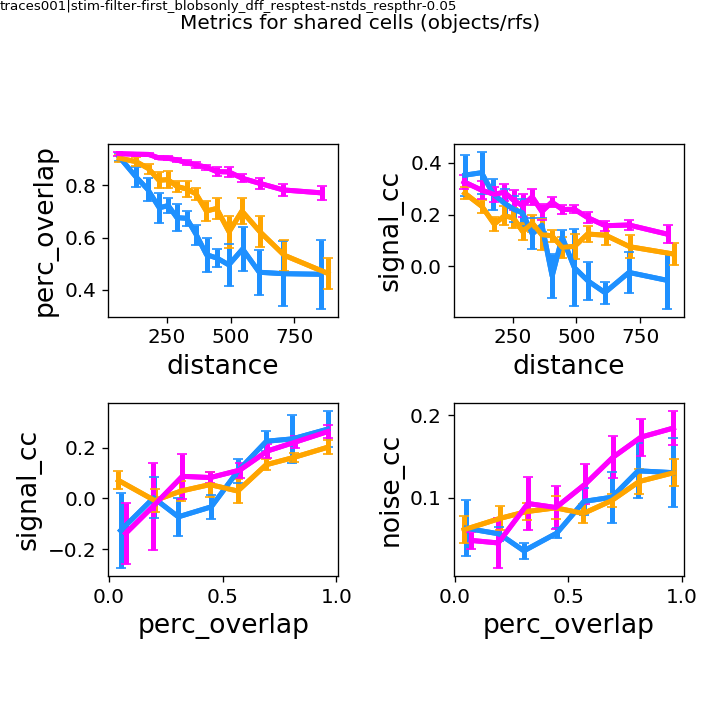

('/n/coxfs01/julianarhee/aggregate-visual-areas/correlations', 'rf_and_corr_metrics_avg-fovs_eqpop15___stim-filter-first_blobsonly_dff_resptest-nstds_respthr-0.05')


In [577]:
use_std = False

fig, axn = pl.subplots(2,2, figsize=(6,6), sharex=False, sharey=False, dpi=dpi)

ax = axn[0, 0]
x_metric = 'binned_dist'
y_metric = 'perc_overlap'
fig_title = 'Perc. RF overlap by distance'
x_labeler = 'distance' if x_metric == 'binned_dist' else 'perc_overlap'

for visual_area, rdf in plotdf.groupby(['visual_area']):
    ncells_t = len(np.union1d(g['row'].unique(), g['col'].unique())) 
    # Get binned x-axis values for labeling
    bin_dists = [b_df.groupby(['datakey'])[x_labeler].mean().mean() for b, b_df in rdf.groupby([x_metric])]
    # Get corresponding y-value averages
    bin_ccs = [b_df.groupby(['datakey'])[y_metric].mean().mean() for b, b_df in rdf.groupby([x_metric])]
    # .. and error bars
    bin_sems = [spstats.sem(b_df.groupby(['datakey'])[y_metric].mean()) for b, b_df in rdf.groupby([x_metric])]
    bin_stds = [b_df.groupby(['datakey'])[y_metric].mean().std() for b, b_df in rdf.groupby([x_metric])]
    bin_errs = bin_stds if use_std else bin_sems
    # Plot
    ax.plot(bin_dists, bin_ccs, color=area_colors[visual_area], 
           label='%s (%i)' % (visual_area, ncells_t), lw=3)
    ax.errorbar(bin_dists, bin_ccs, yerr=bin_errs, color=area_colors[visual_area], lw=3, capsize=3)
    ax.set_xlabel(x_labeler)
    ax.set_ylabel(y_metric)
#ax.set_title(fig_title, fontsize=12, loc='left')

ax = axn[0, 1]
x_metric = 'binned_dist'
y_metric = 'signal_cc'
fig_title = 'Signal corr. by distance'
x_labeler = 'distance' if x_metric == 'binned_dist' else 'perc_overlap'

for visual_area, rdf in plotdf.groupby(['visual_area']):
    ncells_t = len(np.union1d(g['row'].unique(), g['col'].unique())) 
    # Get binned x-axis values for labeling
    bin_dists = [b_df.groupby(['datakey'])[x_labeler].mean().mean() for b, b_df in rdf.groupby([x_metric])]
    # Get corresponding y-value averages
    bin_ccs = [b_df.groupby(['datakey'])[y_metric].mean().mean() for b, b_df in rdf.groupby([x_metric])]
    # .. and error bars
    bin_sems = [spstats.sem(b_df.groupby(['datakey'])[y_metric].mean()) for b, b_df in rdf.groupby([x_metric])]
    bin_stds = [b_df.groupby(['datakey'])[y_metric].mean().std() for b, b_df in rdf.groupby([x_metric])]
    bin_errs = bin_stds if use_std else bin_sems
    # Plot
    ax.plot(bin_dists, bin_ccs, color=area_colors[visual_area], 
           label='%s (%i)' % (visual_area, ncells_t), lw=3)
    ax.errorbar(bin_dists, bin_ccs, yerr=bin_errs, color=area_colors[visual_area], lw=3, capsize=3)
    ax.set_xlabel(x_labeler)
    ax.set_ylabel(y_metric)
#ax.set_title(fig_title, fontsize=12, loc='left')

ax = axn[1, 0]
x_metric = 'binned_overlap'
y_metric = 'signal_cc'
fig_title = 'Signal corr. by RF overlap'
x_labeler = 'distance' if x_metric == 'binned_dist' else 'perc_overlap'

for visual_area, rdf in plotdf.groupby(['visual_area']):
    ncells_t = len(np.union1d(g['row'].unique(), g['col'].unique())) 
    # Get binned x-axis values for labeling
    bin_dists = [b_df.groupby(['datakey'])[x_labeler].mean().mean() for b, b_df in rdf.groupby([x_metric])]
    # Get corresponding y-value averages
    bin_ccs = [b_df.groupby(['datakey'])[y_metric].mean().mean() for b, b_df in rdf.groupby([x_metric])]
    # .. and error bars
    bin_sems = [spstats.sem(b_df.groupby(['datakey'])[y_metric].mean()) for b, b_df in rdf.groupby([x_metric])]
    bin_stds = [b_df.groupby(['datakey'])[y_metric].mean().std() for b, b_df in rdf.groupby([x_metric])]
    bin_errs = bin_stds if use_std else bin_sems
    # Plot
    ax.plot(bin_dists, bin_ccs, color=area_colors[visual_area], 
           label='%s (%i)' % (visual_area, ncells_t), lw=3)
    ax.errorbar(bin_dists, bin_ccs, yerr=bin_errs, color=area_colors[visual_area], lw=3, capsize=3)
    ax.set_xlabel(x_labeler)
    ax.set_ylabel(y_metric)
#ax.set_title(fig_title, fontsize=12, loc='left')

ax = axn[1, 1]
x_metric = 'binned_overlap'
y_metric = 'noise_cc'
fig_title = 'Noise corr. by RF overlap'
x_labeler = 'distance' if x_metric == 'binned_dist' else 'perc_overlap'

for visual_area, rdf in plotdf.groupby(['visual_area']):
    ncells_t = len(np.union1d(g['row'].unique(), g['col'].unique())) 
    # Get binned x-axis values for labeling
    bin_dists = [b_df.groupby(['datakey'])[x_labeler].mean().mean() for b, b_df in rdf.groupby([x_metric])]
    # Get corresponding y-value averages
    bin_ccs = [b_df.groupby(['datakey'])[y_metric].mean().mean() for b, b_df in rdf.groupby([x_metric])]
    # .. and error bars
    bin_sems = [spstats.sem(b_df.groupby(['datakey'])[y_metric].mean()) for b, b_df in rdf.groupby([x_metric])]
    bin_stds = [b_df.groupby(['datakey'])[y_metric].mean().std() for b, b_df in rdf.groupby([x_metric])]
    bin_errs = bin_stds if use_std else bin_sems
    # Plot
    ax.plot(bin_dists, bin_ccs, color=area_colors[visual_area], 
           label='%s (%i)' % (visual_area, ncells_t), lw=3)
    ax.errorbar(bin_dists, bin_ccs, yerr=bin_errs, color=area_colors[visual_area], lw=3, capsize=3)
    ax.set_xlabel(x_labeler)
    ax.set_ylabel(y_metric)
#ax.set_title(fig_title, fontsize=12, loc='left')

fig.suptitle("Metrics for shared cells (objects/rfs)")
pl.subplots_adjust(top=0.8, bottom=0.2, wspace=0.5, hspace=0.5, left=0.15, right=0.95)
putils.label_figure(fig, data_id)

figname = 'rf_and_corr_metrics_avg-fovs_%s___%s' % (bin_type, filter_str)
pl.savefig(os.path.join(correlations_dir, '%s.svg' % figname))
print(correlations_dir, figname)

In [343]:
bin_ccs

[0.14251137775082801,
 0.21416458481146194,
 0.25517784195265875,
 0.28067622778481333,
 0.25086605055587713]

### Plot individual fovs

<IPython.core.display.Javascript object>


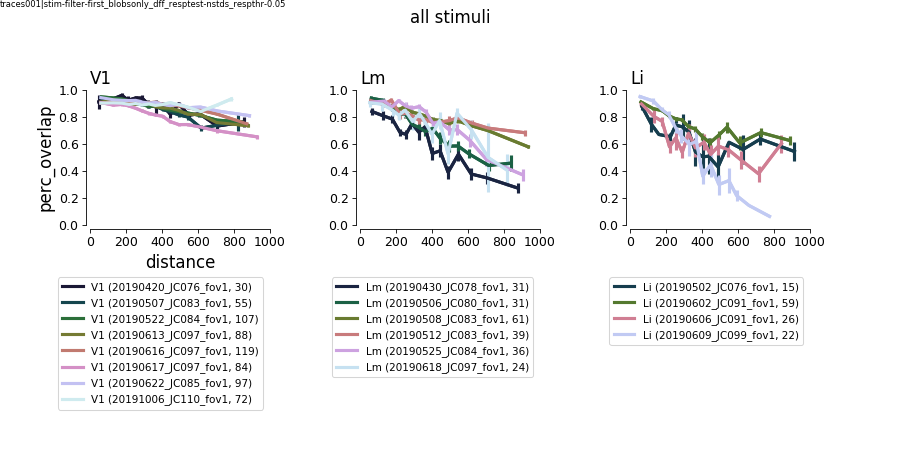

('/n/coxfs01/julianarhee/aggregate-visual-areas/correlations', 'perc_overlap_by_binned_dist_split-fovs_eqpop15___stim-filter-first_blobsonly_dff_resptest-nstds_respthr-0.05')


In [468]:

fig, axn = pl.subplots(1, 3, figsize=(12,6), sharex=False, sharey=False) #, dpi=dpi)

x_metric = 'binned_dist'
y_metric = 'perc_overlap'
fig_title = 'Perc. RF overlap by distance'
x_labeler = 'distance' if x_metric == 'binned_dist' else 'perc_overlap'

for ax, (visual_area, rdf) in zip(axn.flat[::-1], plotdf.groupby(['visual_area'])):
    dcolors = sns.color_palette('cubehelix', n_colors=len(rdf['datakey'].unique()))
    for dcolor, (dkey, g) in zip(dcolors, rdf.groupby(['datakey'])):
        ncells_t = len(np.union1d(g['row'].unique(), g['col'].unique())) #len(g['row'].unique())]) # for dk, g in currdf.groupby(['datakey'])])
        bin_dists = [b_df[x_labeler].mean() for b, b_df in g.groupby([x_metric])]  
        bin_ccs = [b_df[y_metric].mean() for b, b_df in g.groupby([x_metric])]
        bin_sems = [spstats.sem(b_df[y_metric]) for b, b_df in g.groupby([x_metric])]    
        # plot
        ax.plot(bin_dists, bin_ccs, color=dcolor, 
               label='%s (%s, %i)' % (visual_area, dkey, ncells_t), lw=3)
        ax.errorbar(bin_dists, bin_ccs, yerr=bin_sems, color=dcolor, lw=3)
    ax.set_ylabel('')
    ax.set_ylim([0, 1])
    ax.set_xticks(np.linspace(0, 1000, 6))
    ax.set_title(visual_area, loc='left', fontsize=16)
    ax.legend(bbox_to_anchor=(0.99, -0.35)) #1))

axn[0].set_ylabel(y_metric)
axn[0].set_xlabel(x_labeler)

for ax in axn.flat:
    sns.despine(trim=True, offset=4, ax=ax)

pl.suptitle('%s stimuli' % include_stimuli, fontsize=16)
pl.subplots_adjust(wspace=0.5, hspace=0.3, bottom=0.5, top=0.8, left=0.1)

putils.label_figure(fig, data_id)
figname = '%s_by_%s_split-fovs_%s___%s' % (y_metric, x_metric, bin_type, filter_str)
pl.savefig(os.path.join(correlations_dir, '%s.svg' % figname))
print(correlations_dir, figname)

In [444]:
correlations_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/correlations'

In [578]:
plotdf.head()

,row,col,signal_cc,session,datakey,visual_area,fovnum,animalid,noise_cc,area_overlap,perc_overlap,distance,binned_dist,binned_overlap
0,7,24,0.655716,20190420,20190420_JC076_fov1,V1,1,JC076,0.409519,1036.280440,0.907661,268.132066,4.0,7
1,7,25,0.138366,20190420,20190420_JC076_fov1,V1,1,JC076,0.261591,1260.666831,0.897161,312.988786,6.0,7
2,7,26,0.369180,20190420,20190420_JC076_fov1,V1,1,JC076,0.405807,1098.959686,0.782081,280.435363,5.0,6
3,7,32,0.234836,20190420,20190420_JC076_fov1,V1,1,JC076,0.379015,1134.460302,0.927412,458.066500,9.0,7
4,7,42,-0.323832,20190420,20190420_JC076_fov1,V1,1,JC076,0.080457,909.171355,0.966212,187.246909,2.0,7


In [ ]:

fig, axn = pl.subplots(1, 3, figsize=(12,6), sharex=False, sharey=False) #, dpi=dpi)

x_metric = 'binned_dist'
y_metric = 'perc_overlap'
fig_title = 'Perc. RF overlap by distance'
x_labeler = 'distance' if x_metric == 'binned_dist' else 'perc_overlap'

for ax, (visual_area, rdf) in zip(axn.flat[::-1], plotdf.groupby(['visual_area'])):
    dcolors = sns.color_palette('cubehelix', n_colors=len(rdf['datakey'].unique()))
    for dcolor, (dkey, g) in zip(dcolors, rdf.groupby(['datakey'])):
        ncells_t = len(np.union1d(g['row'].unique(), g['col'].unique())) #len(g['row'].unique())]) # for dk, g in currdf.groupby(['datakey'])])
        bin_dists = [b_df[x_labeler].mean() for b, b_df in g.groupby([x_metric])]  
        bin_ccs = [b_df[y_metric].mean() for b, b_df in g.groupby([x_metric])]
        bin_sems = [spstats.sem(b_df[y_metric]) for b, b_df in g.groupby([x_metric])]    
        # plot
        ax.plot(bin_dists, bin_ccs, color=dcolor, 
               label='%s (%s, %i)' % (visual_area, dkey, ncells_t), lw=3)
        ax.errorbar(bin_dists, bin_ccs, yerr=bin_sems, color=dcolor, lw=3)
    ax.set_ylabel('')
    ax.set_ylim([0, 1])
    ax.set_xticks(np.linspace(0, 1000, 6))
    ax.set_title(visual_area, loc='left', fontsize=16)
    ax.legend(bbox_to_anchor=(0.99, -0.35)) #1))

axn[0].set_ylabel(y_metric)
axn[0].set_xlabel(x_labeler)

for ax in axn.flat:
    sns.despine(trim=True, offset=4, ax=ax)

pl.suptitle('%s stimuli' % include_stimuli, fontsize=16)
pl.subplots_adjust(wspace=0.5, hspace=0.3, bottom=0.5, top=0.8, left=0.1)

putils.label_figure(fig, data_id)
figname = '%s_by_%s_split-fovs_%s___%s' % (y_metric, x_metric, bin_type, filter_str)
pl.savefig(os.path.join(correlations_dir, '%s.svg' % figname))
print(correlations_dir, figname)

<IPython.core.display.Javascript object>


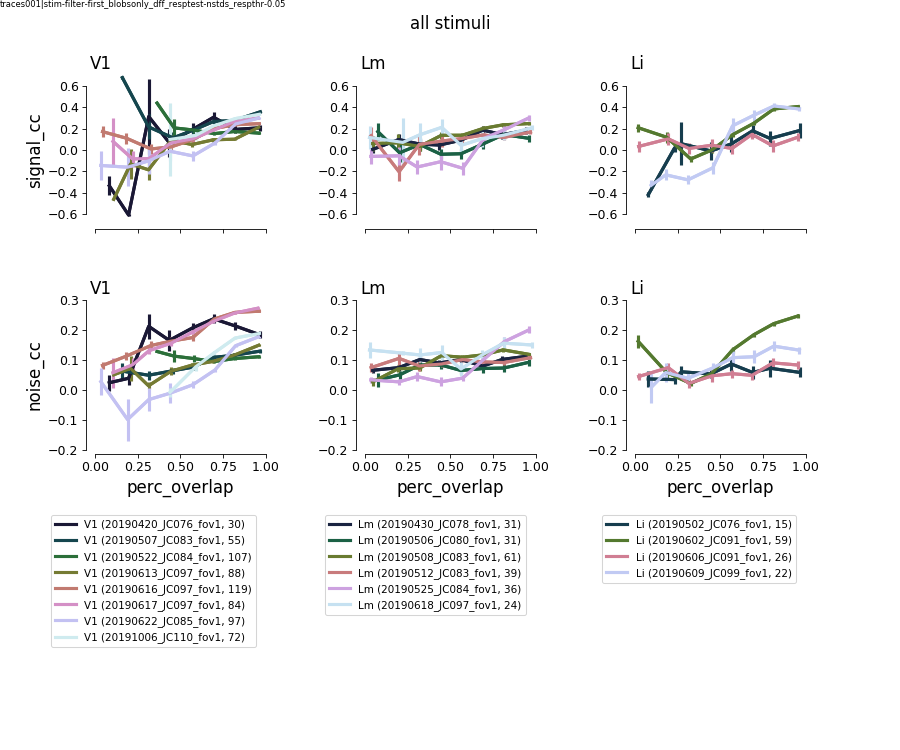

('/n/coxfs01/julianarhee/aggregate-visual-areas/correlations', 'corrcoefs_by_binned_overlap_split-fovs_eqpop15___stim-filter-first_blobsonly_dff_resptest-nstds_respthr-0.05')


In [478]:
fig, axn = pl.subplots(2, 3, figsize=(12,10), sharex=True, sharey=False) #, dpi=dpi)

x_metric = 'binned_overlap'
y_metric = 'signal_cc'
fig_title = 'Signal corr. by RF overlap'
x_labeler = 'distance' if x_metric == 'binned_dist' else 'perc_overlap'
# Noise corrs
for ax, (visual_area, rdf) in zip(axn.flat[0:3][::-1], plotdf.groupby(['visual_area'])):
    dcolors = sns.color_palette('cubehelix', n_colors=len(rdf['datakey'].unique()))
    for dcolor, (dkey, g) in zip(dcolors, rdf.groupby(['datakey'])):

        ncells_t = len(np.union1d(g['row'].unique(), g['col'].unique())) #len(g['row'].unique())]) # for dk, g in currdf.groupby(['datakey'])])
        bin_dists = [b_df[x_labeler].mean() for b, b_df in g.groupby([x_metric])]  
        bin_ccs = [b_df[y_metric].mean() for b, b_df in g.groupby([x_metric])]
        bin_sems = [spstats.sem(b_df[y_metric]) for b, b_df in g.groupby([x_metric])]    
        # plot
        ax.plot(bin_dists, bin_ccs, color=dcolor, 
               label='%s (%s, %i)' % (visual_area, dkey, ncells_t), lw=3)
        ax.errorbar(bin_dists, bin_ccs, yerr=bin_sems, color=dcolor, lw=3)
    ax.set_ylabel('')
    #ax.legend(bbox_to_anchor=(0.95, -0.3)) #1))
    ax.set_title(visual_area, loc='left', fontsize=16)
    ax.set_ylim([-0.7, 0.7])
    #ax.set_xticks(np.linspace(0, 1000, 6))
axn[0,0].set_ylabel(y_metric)
#axn[0,0].set_xlabel(x_labeler)


x_metric = 'binned_overlap'
y_metric = 'noise_cc'
fig_title = 'Noise corr. by RF overlap'
x_labeler = 'distance' if x_metric == 'binned_dist' else 'perc_overlap'

# Noise corrs
for ax, (visual_area, rdf) in zip(axn.flat[3:6][::-1], plotdf.groupby(['visual_area'])):
    dcolors = sns.color_palette('cubehelix', n_colors=len(rdf['datakey'].unique()))
    for dcolor, (dkey, g) in zip(dcolors, rdf.groupby(['datakey'])):

        ncells_t = len(np.union1d(g['row'].unique(), g['col'].unique())) #len(g['row'].unique())]) # for dk, g in currdf.groupby(['datakey'])])
        bin_dists = [b_df[x_labeler].mean() for b, b_df in g.groupby([x_metric])]  
        bin_ccs = [b_df[y_metric].mean() for b, b_df in g.groupby([x_metric])]
        bin_sems = [spstats.sem(b_df[y_metric]) for b, b_df in g.groupby([x_metric])]    
        # plot
        ax.plot(bin_dists, bin_ccs, color=dcolor, 
               label='%s (%s, %i)' % (visual_area, dkey, ncells_t), lw=3)
        ax.errorbar(bin_dists, bin_ccs, yerr=bin_sems, color=dcolor, lw=3)
    ax.set_ylabel('')
    ax.legend(bbox_to_anchor=(0.95, -0.4)) #1))
    ax.set_title(visual_area, loc='left', fontsize=16)
    #ax.set_xticks(np.linspace(0, 1000, 6))
    ax.set_ylim([-0.2, 0.3])
axn[1,0].set_ylabel(y_metric)
for ai in np.arange(0, 3):
    axn[1,ai].set_xlabel(x_labeler)


for ax in axn.flat:
    sns.despine(trim=True, offset=4, ax=ax)

pl.suptitle('%s stimuli' % include_stimuli, fontsize=16)
pl.subplots_adjust(wspace=0.5, hspace=0.5, bottom=0.4, top=0.9, left=0.1)

putils.label_figure(fig, data_id)
figname = 'corrcoefs_by_%s_split-fovs_%s___%s' % (x_metric, bin_type, filter_str)
pl.savefig(os.path.join(correlations_dir, '%s.svg' % figname))
print(correlations_dir, figname)


In [485]:
curr_datakeys = plotdf['datakey'].unique()
curr_rfdf = RFs[RFs['datakey'].isin(curr_datakeys)]
screeninfo = aggr.get_aggregate_stimulation_info(curr_rfdf)

Creating session object [JC076|20190502|FOV1_zoom2p0x]
... found 1 anatomical runs.
Creating blobs object [JC076|20190502|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
[JC076|20190502] not found: gratings
Stimuli presented at coords: (-5, 8)
Creating session object [JC091|20190602|FOV1_zoom2p0x]
... found 1 anatomical runs.
Creating blobs object [JC091|20190602|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
Creating gratings object [JC091|20190602|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_gratings_static
Stimuli presented at coords: (20, -8)
Creating session object [JC091|20190606|FOV1_zoom2p0x]
... found 1 anatomical runs.
Creating blobs object [JC091|20190606|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
Creating gratings object [JC091|20190606|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_gratings_static
Stimuli presented at coords: (20, -8)
Creati

In [486]:
visual_areas = ['V1', 'Lm', 'Li']

In [487]:
screenleft = float(screeninfo['screen_left'].unique())
screenright = float(screeninfo['screen_right'].unique())
screentop = float(screeninfo['screen_top'].unique())
screenbottom = float(screeninfo['screen_bottom'].unique())
screenaspect = float(screeninfo['screen_xres'].unique()) / float(screeninfo['screen_yres'].unique())


<IPython.core.display.Javascript object>


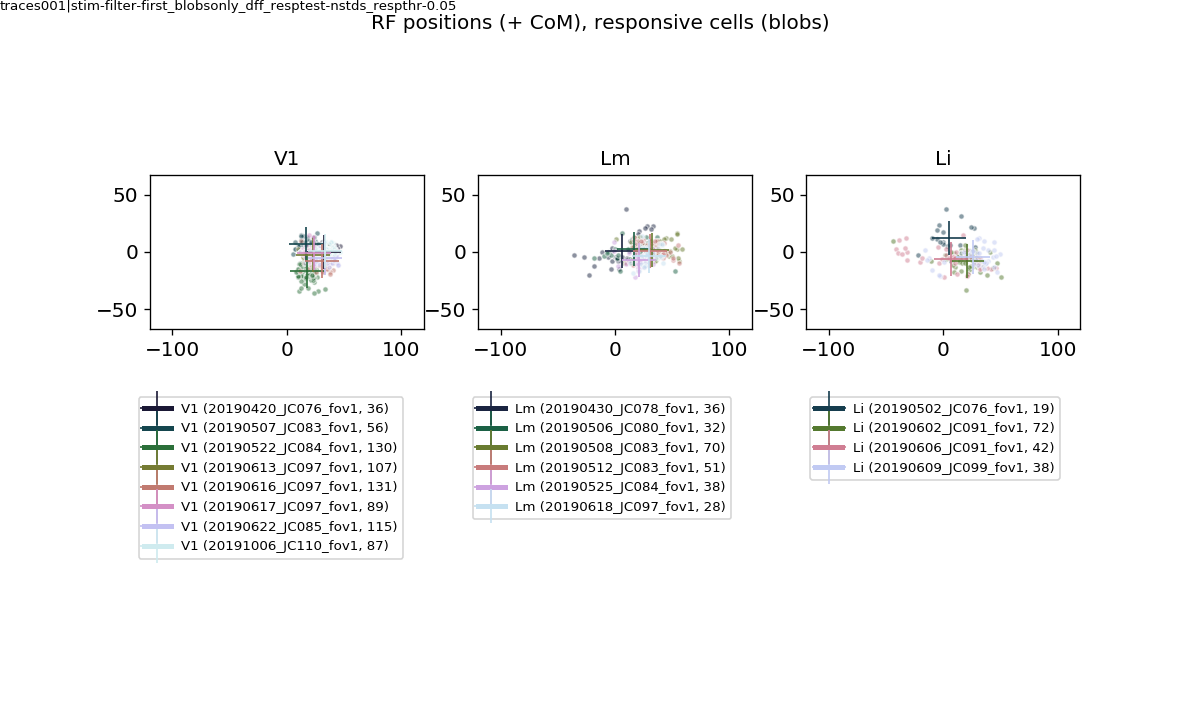

('/n/coxfs01/julianarhee/aggregate-visual-areas/correlations', 'CoM_label-fovs_common_to_blobs_and_rfs')


In [573]:

fig, axn = pl.subplots(1,3, figsize=(10,6), dpi=dpi)
for visual_area, v_df in curr_rfdf.groupby(['visual_area']):
    ai = visual_areas.index(visual_area)
    ax = axn[ai]
    dcolors = sns.color_palette('cubehelix', n_colors=len(v_df['datakey'].unique()))
    for di, (datakey, d_df) in enumerate(v_df.groupby(['datakey'])):
        sns.scatterplot('x0', 'y0', data=d_df, ax=ax, color=dcolors[di],
                        #palette=dcolors, #area_colors[visual_area],
                       s=10, marker='o', alpha=0.5) #, edgecolor='k') #area_colors[visual_area])

        x = d_df['x0'].values
        y=d_df['y0'].values
        
        ncells_t = d_df.shape[0]
        m=np.ones(d_df['x0'].shape)
        cgx = np.sum(x*m)/np.sum(m)
        cgy = np.sum(y*m)/np.sum(m)
        #print('The center of mass: (%.2f, %.2f)' % (cgx, cgy))
        ax.plot(cgx, cgy, marker='+', markersize=20, color=dcolors[di], #area_colors[visual_area],
                label='%s (%s, %i)' % (visual_area, datakey, ncells_t), lw=3)
        
    ax.set_title(visual_area)
    ax.legend(bbox_to_anchor=(0.95, -0.4), fontsize=8) #1))

for ax in axn:
    ax.set_xlim([screenleft, screenright])
    ax.set_ylim([screenbottom, screentop])
    ax.set_aspect('equal')
    ax.set_ylabel('')
    ax.set_xlabel('')
    
pl.suptitle("RF positions (+ CoM), responsive cells (%s)" % experiment)
pl.subplots_adjust(top=0.9, bottom=0.4)


putils.label_figure(fig, data_id)
figname = 'CoM_label-fovs_common_to_blobs_and_rfs'
pl.savefig(os.path.join(correlations_dir, '%s.svg' % figname))
print(correlations_dir, figname)

In [514]:
reload(util)

<module 'pipeline.python.classifications.experiment_classes' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py'>

In [522]:
experiment = 'blobs'

# TEST
animalid = 'JC110'
session = '20191006'
fovnum = 1

datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
print(datakey)
S = util.Session(animalid, session, 'FOV%i_zoom2p0x' % fovnum)
stim_xpos, stim_ypos = S.get_stimulus_coordinates(experiments=[experiment])
stim_sizes = S.get_stimulus_sizes(size_tested=[experiment])

20191006_JC110_fov1
Creating session object [JC110|20191006|FOV1_zoom2p0x]
... found 1 anatomical runs.
Creating blobs object [JC110|20191006|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
Stimuli presented at coords: (30, 0)
Creating blobs object [JC110|20191006|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static


In [545]:
g = RFs[RFs['datakey']==datakey].copy()

# Convert RF fit params to polygon
g.index = g['cell'].values
rf_polys = rfutils.rfs_to_polys(g[rf_fit_params])

# Convert stimuli to polyon bounding boxes
stim_polys = [(blob_sz, rfutils.stimsize_poly(blob_sz, xpos=stim_xpos, ypos=stim_ypos)) \
              for blob_sz in stim_sizes[experiment]]

In [558]:
perc_overlap = pd.concat([rfutils.get_proportion_overlap(rf_poly, stim_poly) \
                          for stim_poly in stim_polys for rf_poly in rf_polys]).rename(columns={'row': 'cell', 'col': 'stim_size'})

print(perc_overlap)


    area_overlap  stim_size  perc_overlap  cell
0     100.000000         10      1.000000     4
0     100.000000         10      1.000000     5
0     100.000000         10      1.000000     6
0     100.000000         10      1.000000    11
0     100.000000         10      1.000000    12
0     100.000000         10      1.000000    18
0     100.000000         10      1.000000    19
0     100.000000         10      1.000000    23
0     100.000000         10      1.000000    27
0     100.000000         10      1.000000    29
0     100.000000         10      1.000000    32
0     100.000000         10      1.000000    33
0     100.000000         10      1.000000    34
0     100.000000         10      1.000000    55
0     100.000000         10      1.000000    58
0     100.000000         10      1.000000    71
0     100.000000         10      1.000000    76
0     100.000000         10      1.000000    79
0     100.000000         10      1.000000    85
0     100.000000         10      1.00000

<IPython.core.display.Javascript object>


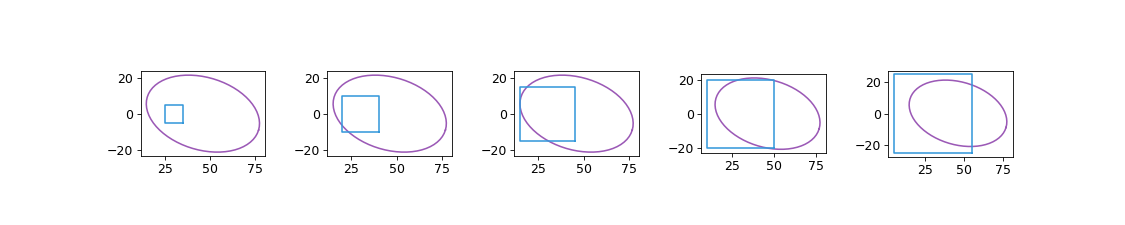

(0, array([ 1.]))
(1, array([ 0.98490634]))
(2, array([ 0.87268534]))
(3, array([ 0.71196589]))
(4, array([ 0.67870541]))


In [544]:
fig, axn = pl.subplots(1,5, figsize=(15,3))

p_rf = rf_polys[0][1]

p_stim = stim_polys[0]
for stim_ix, p_stim in enumerate(stim_polys):
    ax = axn[stim_ix]

    perc_overlap = rfutils.get_proportion_overlap(rf_polys[0], (stim_ix, p_stim))
    #print(perc_overlap)

    x, y = p_rf.exterior.xy
    ax.plot(x, y)
    #ax.set_title(perc_overlap, fontsize=8)
    print(stim_ix, perc_overlap['perc_overlap'].values)

    x, y = p_stim.exterior.xy
    ax.plot(x, y)
    ax.set_aspect('equal')
pl.subplots_adjust(wspace=0.5)

In [541]:
perc_overlap

,area_overlap,col,perc_overlap,row
0,1362.427146,4,0.678705,4


In [560]:
o_list=[]
for (visual_area, animalid, session, fovnum, datakey), g in RFs.groupby(['visual_area', 'animalid', 'session', 'fovnum', 'datakey']):

    # Convert RF fit params to polygon
    g.index = g['cell'].values
    rf_polys = rfutils.rfs_to_polys(g[rf_fit_params])

    # Convert stimuli to polyon bounding boxes
    stim_polys = [(blob_sz, rfutils.stimsize_poly(blob_sz, xpos=stim_xpos, ypos=stim_ypos)) \
                  for blob_sz in stim_sizes[experiment]]
    
    # Get all pairwise overlaps (% of smaller ellipse that overlaps larger ellipse)
    overlaps = pd.concat([rfutils.get_proportion_overlap(rf_poly, stim_poly) \
                for stim_poly in stim_polys for rf_poly in rf_polys]).rename(columns={'row': 'cell', 'col': 'stim_size'})
    metadict={'visual_area': visual_area, 'animalid': animalid, 
              'session': session, 'fovnum': fovnum, 'datakey': datakey}
    o_ = putils.add_meta_to_df(overlaps, metadict)
    o_list.append(o_)

stim_overlaps = pd.concat(o_list, axis=0).reset_index(drop=True)

<IPython.core.display.Javascript object>


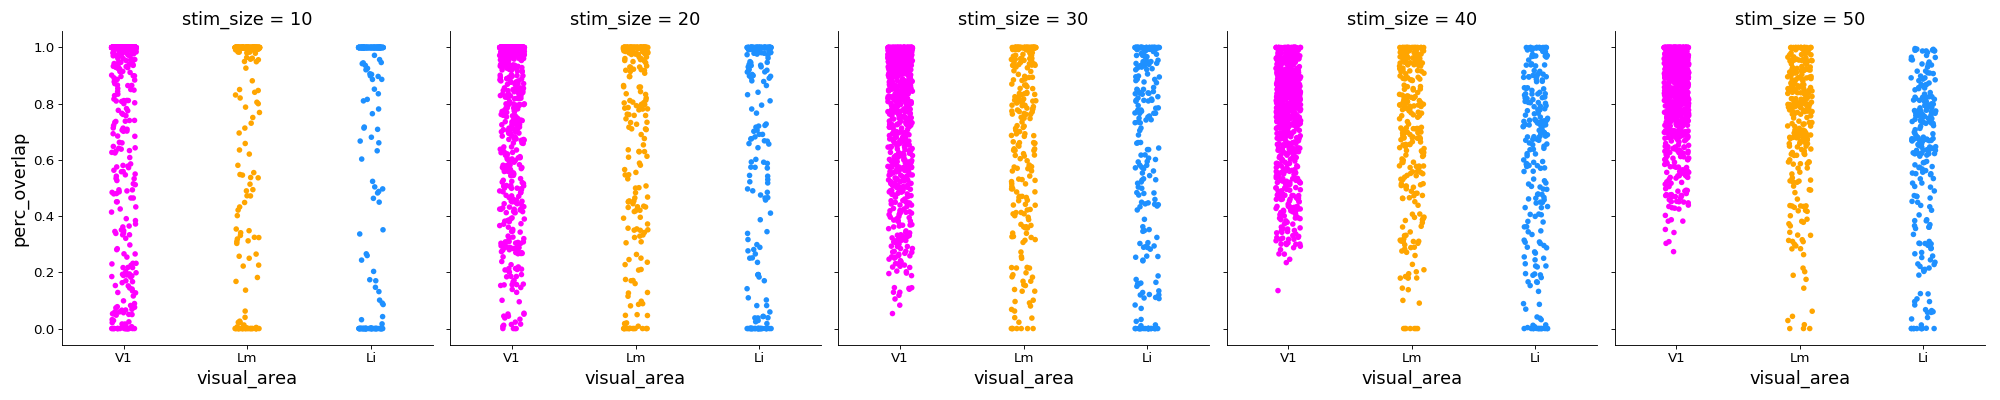

In [568]:
sns.catplot(x='visual_area', y='perc_overlap', col='stim_size', data=stim_overlaps,
           kind='strip', palette=area_colors, order=visual_areas)

In [679]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

import scipy.stats as spstats
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


In [878]:
d_list = []
for (visual_area, datakey), g in stim_overlaps.groupby(['visual_area', 'datakey']):
    if datakey not in MEANS.keys():
        print("no %s: %s" % (experiment, datakey))
        continue
        
    exp_rids = [r for r in MEANS[datakey].columns if putils.isnumber(r)]
    rf_rids = sorted(g['cell'].unique())
    common_rids = np.intersect1d(exp_rids, rf_rids)
    print("[%s] %s, %i cells" % (visual_area, datakey, len(common_rids)))
    
    d_list.append(g[g['cell'].isin(common_rids)].copy())
has_blobs = pd.concat(d_list, axis=0)
print(has_blobs.shape)
    
    

[Li] 20190502_JC076_fov1, 15 cells
[Li] 20190602_JC091_fov1, 59 cells
[Li] 20190605_JC090_fov1, 9 cells
[Li] 20190606_JC091_fov1, 26 cells
[Li] 20190609_JC099_fov1, 22 cells
[Li] 20190617_JC099_fov1, 4 cells
[Li] 20191018_JC113_fov1, 6 cells
[Li] 20191105_JC117_fov1, 0 cells
[Li] 20191111_JC120_fov1, 1 cells
[Lm] 20190430_JC078_fov1, 31 cells
[Lm] 20190504_JC078_fov1, 10 cells
[Lm] 20190506_JC080_fov1, 31 cells
[Lm] 20190508_JC083_fov1, 61 cells
[Lm] 20190512_JC083_fov1, 39 cells
[Lm] 20190525_JC084_fov1, 36 cells
[Lm] 20190618_JC097_fov1, 24 cells
[Lm] 20190627_JC091_fov1, 6 cells
[V1] 20190420_JC076_fov1, 30 cells
[V1] 20190507_JC083_fov1, 55 cells
[V1] 20190522_JC084_fov1, 107 cells
[V1] 20190613_JC097_fov1, 88 cells
[V1] 20190616_JC097_fov1, 119 cells
[V1] 20190617_JC097_fov1, 84 cells
[V1] 20190622_JC085_fov1, 97 cells
[V1] 20191006_JC110_fov1, 72 cells
(5160, 9)


In [618]:
# d_list=[]
# for (visual_area, datakey), rdf in RFs.groupby(['visual_area', 'datakey']):

#     exp_rids = [r for r in MEANS[datakey].columns if putils.isnumber(r)]
#     rf_rids = sorted(rdf['cell'].unique())
#     common_rids = np.intersect1d(exp_rids, rf_rids)
#     #print("[%s] %s, %i cells" % (visual_area, datakey, len(common_rids)))
#     d_list.append(rdf[rdf['cell'].isin(common_rids)].copy())
# common_rfs = pd.concat(d_list, axis=0)
# common_rfs.shape

(1032, 28)

In [879]:
has_blobs[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()

,datakey,cell
visual_area,,
Li,142,142
Lm,238,238
V1,652,652


In [927]:
overlap_int = 0.2
overlap_thr_values = np.arange(0, 1+overlap_int, overlap_int)

for overlap_thr in overlap_thr_values:
    pdf = has_blobs[has_blobs['perc_overlap']>=overlap_thr].copy()
    print("Thr: %.2f --------------" % overlap_thr)
    print(pdf[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())

Thr: 0.00 --------------
             datakey  cell
visual_area               
Li               142   142
Lm               238   238
V1               652   652
Thr: 0.20 --------------
             datakey  cell
visual_area               
Li               131   131
Lm               232   232
V1               652   652
Thr: 0.40 --------------
             datakey  cell
visual_area               
Li               114   114
Lm               218   218
V1               647   647
Thr: 0.60 --------------
             datakey  cell
visual_area               
Li               108   108
Lm               206   206
V1               620   620
Thr: 0.80 --------------
             datakey  cell
visual_area               
Li               100   100
Lm               185   185
V1               572   572
Thr: 1.00 --------------
             datakey  cell
visual_area               
Li                89    89
Lm               155   155
V1               473   473


In [929]:
overlap_thr = 1.0
has_blobs[has_blobs['perc_overlap']>=overlap_thr][['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()

,datakey,cell
visual_area,,
Li,89,89
Lm,155,155
V1,473,473


In [908]:
has_blobs[has_blobs['perc_overlap']>overlap_thr][['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()['cell']

visual_area
Li    100
Lm    185
V1    572
Name: cell, dtype: int64

In [909]:
has_blobs[has_blobs['perc_overlap']>overlap_thr][['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()['cell'].min()

100

In [912]:
curr_min_pass = has_blobs[has_blobs['perc_overlap']>overlap_thr][['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()['cell'].min()

maxn = min([128, curr_min_pass])
NCELLS = [4, 8, 16, 32, 64, maxn]

# overlap_df = has_blobs[has_blobs['perc_overlap']>overlap_thr].copy()
# curr_ncells=NCELLS[0]

n_iterations=50
exact_trials=False

In [913]:
def filter_rois(has_blobs, overlap_thr=0.50):
    visual_areas=['V1', 'Lm', 'Li']
    nocells=[]; notrials=[];
    global_rois = dict((v, []) for v in visual_areas)
    roi_counters = dict((v, 0) for v in visual_areas)
    roidf = []
    datakeys = dict((v, []) for v in visual_areas)
    
    for (visual_area, datakey), g in has_blobs[has_blobs['perc_overlap']>=overlap_thr].groupby(['visual_area', 'datakey']):
#         if datakey not in MEANS.keys():
#             print('... skipping %s' % datakey)
#             continue
        # ddf = MEANS[datakey].copy() #.items():

        #visual_area = sdata[sdata['datakey']==datakey]['visual_area'].unique()[0]
        roi_counter = roi_counters[visual_area]
        datakeys[visual_area].append(datakey)

        # For now, only take dsets w/ specified N trials
#         if exact_trials and ddf.shape[0] != ntrials_expected:
#             print("wrong n trials (%i)" % NEURALDATA[datakey]['data'].shape[0] )
#             notrials.append('%s_%s' % (visual_area, datakey))
#             continue

        #ddf.sort_values(by='config')
        roi_list = sorted([s for s in g['cell'].unique()]) #[int(r) for r in ddf.columns if r != 'config']

#         # Get ROIs with RF fits and threshold by lum-ratio
#         curr_lumdf = lumdf[lumdf['datakey']==datakey]
#         rfexp = 'rfs10' if 'rfs10' in curr_lumdf['experiment'].unique() else 'rfs'
#         meanlrs = curr_lumdf[curr_lumdf['experiment']==rfexp].groupby(['rid']).mean()
#         lum_rois = meanlrs[meanlrs['L_ratio']>=luminance_thr].index.tolist()
#         pass_rois_lum = [r for r in lum_rois if r in curr_rois]

#         # Get ROIs with RF fits and threshold by overlap-percentage
#         mean_overlaps = overlaprois[overlaprois['datakey']==datakey].groupby(['rid']).mean()
#         coverage_rois = mean_overlaps[mean_overlaps['overlap']>=overlap_thr].index.tolist()
#         pass_rois_overlap = [r for r in coverage_rois if r in curr_rois]
        
#         #print("RF-lum-thr: %i/%i, Overlap-thr: %i/%i" % (len(pass_rois_lum), len(lum_rois), len(pass_rois_overlap), len(coverage_rois)))
#         roi_list = np.intersect1d(pass_rois_lum, pass_rois_overlap)
#         #print("%i rois common to both." % len(roi_list))    
#         if len(roi_list) == 0:
#             nocells.append('%s_%s' % (visual_area, datakey))
#             continue

        # Reindex roi ids for global
        roi_ids = [i+roi_counter for i, r in enumerate(roi_list)]
        nrs = len(roi_list)

        global_rois[visual_area].extend(roi_ids)
        roidf.append(pd.DataFrame({'roi': roi_ids,
                                   'dset_roi': roi_list,
                                   'visual_area': [visual_area for _ in np.arange(0, nrs)],
                                   'datakey': [datakey for _ in np.arange(0, nrs)]}))

        # Update global roi id counter
        roi_counters[visual_area] += len(roi_ids)

    roidf = pd.concat(roidf, axis=0) #.groupby(['visual_area']).count()
    #print("%i datasets fail all thresholds:" % len(nocells), nocells)
    for k, v in global_rois.items():
        print(k, len(v))
        
    return roidf

In [903]:
# overlap_thr=0.8
# globaldf = filter_rois(has_blobs[has_blobs['datakey'].isin(stim_datakeys)], overlap_thr=overlap_thr) ##sdata_exp, MEANS, overlap_thr=0.8)


('V1', 572)
('Lm', 185)
('Li', 100)


# Linear separability, by RF overlap

In [1075]:
import sklearn.metrics as skmetrics
import random

def computeMI(x, y):
    sum_mi = 0.0
    x_value_list = np.unique(x)
    y_value_list = np.unique(y)
    Px = np.array([ len(x[x==xval])/float(len(x)) for xval in x_value_list ]) #P(x)
    Py = np.array([ len(y[y==yval])/float(len(y)) for yval in y_value_list ]) #P(y)
    for i in xrange(len(x_value_list)):
        if Px[i] ==0.:
            continue
        sy = y[x == x_value_list[i]]
        if len(sy)== 0:
            continue
        pxy = np.array([len(sy[sy==yval])/float(len(y))  for yval in y_value_list]) #p(x,y)
        t = pxy[Py>0.]/Py[Py>0.] /Px[i] # log(P(x,y)/( P(x)*P(y))
        sum_mi += sum(pxy[t>0]*np.log2( t[t>0]) ) # sum ( P(x,y)* log(P(x,y)/( P(x)*P(y)) )
    return sum_mi

In [1054]:
SDF={}
for datakey, g in globaldf.groupby(['datakey']):
    session, animalid, fov_ = datakey.split('_')
    fovnum = int(fov_[3:])
    obj = util.Objects(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
    sdf = obj.get_stimuli()
    SDF[datakey] = sdf

Creating blobs object [JC076|20190420|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
Creating blobs object [JC078|20190430|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
Creating blobs object [JC076|20190502|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
Creating blobs object [JC078|20190504|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
Creating blobs object [JC080|20190506|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
Creating blobs object [JC083|20190507|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
Creating blobs object [JC083|20190508|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
Creating blobs object [JC083|20190512|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
Creating blobs object [JC084|20190522|FOV1_zoom2p0x|traces001]
... getti

In [1093]:
for k, d in SDF.items():
    if len(np.where(sdf['morphlevel']!=d['morphlevel'])[0]) > 0:
        print(k)
    if len(np.where(sdf['size']!=d['size'])[0]) > 0:
        print(k)


In [1466]:
decoding_dir = os.path.join(aggregate_dir, 'decoding', 'linear-separability')
if not os.path.exists(decoding_dir):
    os.makedirs(decoding_dir)
print(decoding_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/linear-separability


In [1467]:
overlap_thr_int = 0.2
overlap_thr_values = np.arange(0, 1+overlap_thr_int, overlap_thr_int)

NCELLS = [2, 4, 6, 16, 32, 48, 64, 86, 100]
ncells_dict = dict((k, NCELLS) for k in overlap_thr_values)
print(ncells_dict)

{0.0: [2, 4, 6, 16, 32, 48, 64, 86, 100], 1.0: [2, 4, 6, 16, 32, 48, 64, 86, 100], 0.40000000000000002: [2, 4, 6, 16, 32, 48, 64, 86, 100], 0.80000000000000004: [2, 4, 6, 16, 32, 48, 64, 86, 100], 0.60000000000000009: [2, 4, 6, 16, 32, 48, 64, 86, 100], 0.20000000000000001: [2, 4, 6, 16, 32, 48, 64, 86, 100]}


In [1479]:
m0=0
m100=53
print(m0, m100)

(0, 53)


In [1480]:
n_iterations = 500

In [ ]:
#if load_popdata:
    
popdf = []
popdf_chance = []
i = 0
overlap_thr=0.8

#for overlap_thr, NCELLS in ncells_dict.items():
print("-------- Overlap: %.2f --------" % overlap_thr)
# Get list of eligible cells from all FOVs
globaldf = filter_rois(has_blobs[has_blobs['datakey'].isin(stim_datakeys)], overlap_thr=overlap_thr) 

for curr_ncells in NCELLS:
    for visual_area, gdf in globaldf.groupby(['visual_area']):
        print("... [%s] popn size: %i" % (visual_area, curr_ncells))

        iter_results=[]; iter_test_results=[];
        iter_results_chance=[]; iter_test_results_chance=[];
        for iteration in np.arange(0, n_iterations):
            # Get random selection of NCELLS for current iter (from global ROI list)
            ncells_t = gdf.shape[0]
            curr_rids = np.array(sorted(gdf['roi'].values.copy()))
            # Random w/ replacement
            rand_ixs = np.array([random.randint(0, ncells_t-1) for x in range(curr_ncells)]) #np.random.shuffle(curr_rids)
            curr_roi_list = curr_rids[rand_ixs] #curr_rids[0:curr_ncells]
            curr_roidf = gdf[gdf['roi'].isin(curr_roi_list)].copy()

            # Make sure equal num trials per condition for all dsets
            # Get fewest total n trials among dsets
            fewest_ntrials = np.min([MEANS[k].shape[0] for k in curr_roidf['datakey'].unique()])
            # Get trial counts per cond for dset w. fewest trials
            min_ntrials = []
            keys_with_few = [k for k in curr_roidf['datakey'].unique() if MEANS[k].shape[0]==fewest_ntrials]
            for k in keys_with_few:
                currd = MEANS[k].sort_values(by='config') #[dgroup['dset_roi']]
                min_ntrials.append(currd.groupby(['config']).count().min().min())
            # Set min N trials per condition
            min_ntrials = min(min_ntrials)

            # Get data samples for these cells
            d_list=[]
            for datakey, dgroup in curr_roidf.groupby(['datakey']):
                currd = MEANS[datakey].sort_values(by='config') #[dgroup['dset_roi']]
                min_ntrials = min([min_ntrials, currd.groupby(['config']).count().min().min()])
                # Get subset of trials per cond to match min N trials
                tmp_d=[]
                for cfg, dmat in currd.groupby(['config']):
                    if dmat.shape[0] == min_ntrials:
                        tmp_d.append(dmat)
                    else:
                        tixs = np.arange(0, dmat.shape[0])
                        np.random.shuffle(tixs)
                        currd_subset = dmat.iloc[tixs[0:min_ntrials]].copy()
                        tmp_d.append(currd_subset)
                d_ = pd.concat(tmp_d, axis=0) 
                config_list = d_['config'].values     # Get configs on selected trials
                currd = d_[dgroup['dset_roi']].copy() # Data should only include ROI columns
                currd = currd.reset_index(drop=True)  # Reset trial indices 
                currd.columns = dgroup['roi'].values  # Rename ROI columns to global-rois
                d_list.append(currd)
            curr_data = pd.concat(d_list, axis=1)
            curr_data['config'] = config_list 

            #### Select train/test configs for clf A vs B
            object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
            curr_roi_list = [int(c) for c in curr_data.columns if c != 'config']
            sample_data = curr_data[curr_data['config'].isin(object_configs)]

            #### Equalize df/f across neurons:  Normalize each neuron to have same (zero) mean, (unit) SD across stimuli
            data = sample_data[curr_roi_list]
            zdata = (data - data.mean()) / data.std()

            #### Get labels
            targets = pd.DataFrame(sample_data['config'].copy(), columns=['config'])
            targets['label'] = [sdf.loc[cfg]['morphlevel'][0] for cfg in targets.values]

            stimdf = sdf[sdf['morphlevel'].isin([m0, m100])]
            sizes = sorted(stimdf['size'].unique())

            #### For each transformation, split trials into 80% and 20%
            train_data=[]; test_data=[]; 
            train_labels=[]; test_labels=[]; 
            train_data_chance=[]; test_data_chance=[]; 
            train_labels_chance=[]; test_labels_chance=[]; 
            for sz in sizes: 
                curr_configs = sdf[sdf['size']==sz].index.tolist()
                curr_trials = np.array(targets[targets['config'].isin(curr_configs)].index.tolist())
                xi = zdata.loc[curr_trials]
                yi = targets.loc[curr_trials]['label'].values

                # Split train/test
                train_x, test_x, train_y, test_y = train_test_split(xi, yi, test_size=0.2)
                train_data.append(train_x)
                test_data.append(test_x)
                train_labels.append(train_y)
                test_labels.append(test_y)

            # Aggregate TRAIN/TEST data        
            train_data = np.vstack(train_data)
            train_labels = np.hstack(train_labels)
            test_data = np.vstack(test_data)
            test_labels = np.hstack(test_labels)

            #### DATA - Fit classifier
            svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2')
            scores = cross_validate(svc, train_data, train_labels, cv=5,
                                    scoring=('r2', 'neg_mean_squared_error', 'accuracy'),
                                    return_train_score=True)
            iterdict = dict((s, values.mean()) for s, values in scores.items())

            #### DATA - Test with held-out data
            trained_svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2').fit(train_data, train_labels)
            test_score = trained_svc.score(test_data, test_labels)

            #### DATA - Calculate MI
            predicted_labels = trained_svc.predict(test_data)
            mi = skmetrics.mutual_info_score(test_labels, predicted_labels)
            ami = skmetrics.adjusted_mutual_info_score(test_labels, predicted_labels)
            log2_mi = computeMI(test_labels, predicted_labels)

            iterdict.update({'heldout_test_score': test_score, 
                             'heldout_MI': mi, 'heldout_aMI': ami, 'heldout_log2MI': log2_mi})
            iter_results.append(pd.DataFrame(iterdict, index=[iteration]))

            # ------------------------------------------------------------------
            # Shuffle LABELS to calculate chance level
            train_labels_chance = train_labels.copy()
            np.random.shuffle(train_labels_chance)
            test_labels_chance = test_labels.copy()
            np.random.shuffle(test_labels_chance)

            #### CHANCE - Fit classifier
            svc_chance = LinearSVC(multi_class='ovr', C=C_value, penalty='l2')
            scores_chance = cross_validate(svc, train_data, train_labels_chance, cv=5,
                                    scoring=('r2', 'neg_mean_squared_error', 'accuracy'),
                                    return_train_score=True)
            iterdict_chance = dict((s, values.mean()) for s, values in scores_chance.items())

            # CHANCE - Test with held-out data
            trained_svc_chance = LinearSVC(multi_class='ovr', C=C_value, penalty='l2').fit(train_data, train_labels_chance)
            test_score_chance = trained_svc_chance.score(test_data, test_labels_chance)  
            #iter_test_results_chance.append(test_score_chance)

            # Chance - Calculate MI
            predicted_labels = trained_svc_chance.predict(test_data)
            mi = skmetrics.mutual_info_score(test_labels, predicted_labels)
            ami = skmetrics.adjusted_mutual_info_score(test_labels, predicted_labels)
            log2_mi = computeMI(test_labels, predicted_labels)

            iterdict_chance.update({'heldout_test_score': test_score_chance, 
                                    'heldout_MI': mi, 'heldout_aMI': ami, 'heldout_log2MI': log2_mi})
            iter_results_chance.append(pd.DataFrame(iterdict_chance, index=[iteration]))


        # DATA - get mean across iters
        iter_results = pd.concat(iter_results, axis=0)
        iterdict = dict(iter_results.mean())
        iterdict.update({'n_units': curr_ncells, 
                         'overlap': overlap_thr,
                         'visual_area': visual_area,
                          'heldout_test_sem': spstats.sem(iter_results['heldout_test_score'].values),
                          'heldout_test_std': float(iter_results['heldout_test_score'].std()),
                          'heldout_MI_sem': spstats.sem(iter_results['heldout_MI'].values),
                          'heldout_MI_std': float(iter_results['heldout_MI'].std()),
                          'heldout_aMI_sem': spstats.sem(iter_results['heldout_aMI'].values),
                          'heldout_aMI_std': float(iter_results['heldout_aMI'].std()),
                          'heldout_log2MI_sem': spstats.sem(iter_results['heldout_log2MI'].values),
                          'heldout_log2MI_std': float(iter_results['heldout_log2MI'].std())})
        popdf.append(pd.DataFrame(iterdict, index=[i]))

        # CHANCE - get mean across iters
        iter_results_chance = pd.concat(iter_results_chance, axis=0)
        iterdict_chance = dict(iter_results_chance.mean())
        iterdict_chance.update({'n_units': curr_ncells, 
                                'overlap': overlap_thr,
                                'visual_area': visual_area,
                              'heldout_test_sem': spstats.sem(iter_results_chance['heldout_test_score'].values),
                              'heldout_test_std': float(iter_results_chance['heldout_test_score'].std()),
                              'heldout_MI_sem': spstats.sem(iter_results_chance['heldout_MI'].values),
                              'heldout_MI_std': float(iter_results_chance['heldout_MI'].std()),
                              'heldout_aMI_sem': spstats.sem(iter_results_chance['heldout_aMI'].values),
                              'heldout_aMI_std': float(iter_results_chance['heldout_aMI'].std()),
                              'heldout_log2MI_sem': spstats.sem(iter_results_chance['heldout_log2MI'].values),
                              'heldout_log2MI_std': float(iter_results_chance['heldout_log2MI'].std())})
        popdf_chance.append(pd.DataFrame(iterdict_chance, index=[i]))
        i += 1

pooled = pd.concat(popdf, axis=0)
pooled_chance = pd.concat(popdf_chance, axis=0)
print(pooled.shape, pooled_chance.shape)
pooled.head()

-------- Overlap: 0.80 --------
('V1', 572)
('Lm', 185)
('Li', 100)
... [Li] popn size: 2


<IPython.core.display.Javascript object>


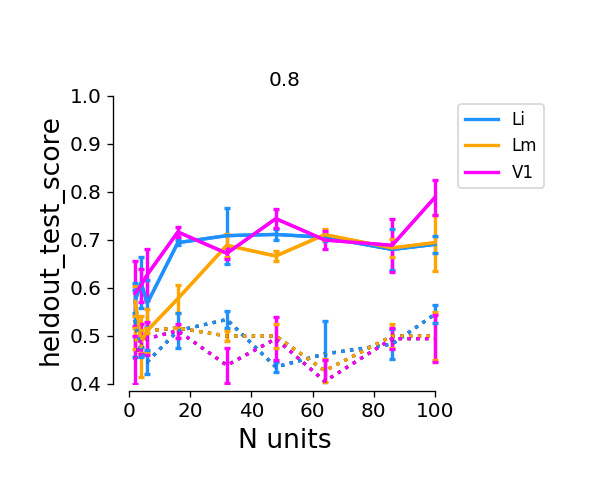

In [1477]:
metric = 'heldout_test_score' #'heldout_aMI' #'heldout_test_score'
metric_base = 'heldout_test' if metric=='heldout_test_score' else metric

lw = 2
capsize=2

fig, ax = pl.subplots(figsize=(5,4), sharex=True, sharey=True, dpi=dpi)
for ai, (visual_area, g) in enumerate(pooled.groupby(['visual_area'])):
    mean_scores = g.sort_values(by='n_units')[metric]
    std_scores = g.sort_values(by='n_units')['%s_sem' % metric_base]
    n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
    ax.plot(n_units_per, mean_scores, color=area_colors[visual_area], 
            alpha=overlap_alphas[overlap_l], lw=lw,
            label='%s' % (visual_area))
    ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                capthick=lw, capsize=capsize, label=None, alpha=1, #overlap_alphas[overlap_l], 
                lw=lw)
ax.legend(bbox_to_anchor=(1., 1))
ax.set_title(overlap_thr)
ax.set_xlabel("N units")
ax.set_ylabel(metric)


for ai, (visual_area, g) in enumerate(pooled_chance.groupby(['visual_area'])):
    mean_scores = g.sort_values(by='n_units')[metric]
    std_scores = g.sort_values(by='n_units')['%s_sem' % metric_base]
    n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
    ax.plot(n_units_per, mean_scores, color='k', #area_colors[visual_area], 
            alpha=overlap_alphas[overlap_l], lw=lw, linestyle=':', 
            label=None)
    ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                capthick=lw, capsize=capsize, label=None, alpha=1, #overlap_alphas[overlap_l], 
                lw=lw, linestyle=':')
if metric=='heldout_test_score':
    ax.set_ylim([0.4, 1.0])
ax.set_ylabel(metric)


sns.despine(trim=True, offset=4)
pl.subplots_adjust(right=0.75, left=0.2, wspace=0.5, bottom=0.2, top=0.8)

# analysis_str = '%i-iters_C%.2f_compare-overlaps' % (n_iterations, C_value)
# putils.label_figure(fig, analysis_str)
   
# figname = '%s_lin-sep_overlap%.2f_C%.2f_niter%i__%s' % (metric, overlap_thr, C_value, n_iterations, response_str)
# pl.savefig(os.path.join(decoding_dir, '%s.svg' % figname))
# # #pl.savefig(os.path.join(decoding_dir, '%s.png' % figname))

# print(figname)

# Get all overlaps, all iters

In [ ]:
#if load_popdata:
    
popdf = []
popdf_chance = []
i = 0
for overlap_thr, NCELLS in ncells_dict.items():
    print("-------- Overlap: %.2f --------" % overlap_thr)
    # Get list of eligible cells from all FOVs
    globaldf = filter_rois(has_blobs[has_blobs['datakey'].isin(stim_datakeys)], overlap_thr=overlap_thr) 

    for curr_ncells in NCELLS:
        for visual_area, gdf in globaldf.groupby(['visual_area']):
            print("... [%s] popn size: %i" % (visual_area, curr_ncells))

            iter_results=[]; iter_test_results=[];
            iter_results_chance=[]; iter_test_results_chance=[];
            for iteration in np.arange(0, n_iterations):
                # Get random selection of NCELLS for current iter (from global ROI list)
                ncells_t = gdf.shape[0]
                curr_rids = np.array(sorted(gdf['roi'].values.copy()))
                # Random w/ replacement
                rand_ixs = np.array([random.randint(0, ncells_t-1) for x in range(curr_ncells)]) #np.random.shuffle(curr_rids)
                curr_roi_list = curr_rids[rand_ixs] #curr_rids[0:curr_ncells]
                curr_roidf = gdf[gdf['roi'].isin(curr_roi_list)].copy()

                # Make sure equal num trials per condition for all dsets
                # Get fewest total n trials among dsets
                fewest_ntrials = np.min([MEANS[k].shape[0] for k in curr_roidf['datakey'].unique()])
                # Get trial counts per cond for dset w. fewest trials
                min_ntrials = []
                keys_with_few = [k for k in curr_roidf['datakey'].unique() if MEANS[k].shape[0]==fewest_ntrials]
                for k in keys_with_few:
                    currd = MEANS[k].sort_values(by='config') #[dgroup['dset_roi']]
                    min_ntrials.append(currd.groupby(['config']).count().min().min())
                # Set min N trials per condition
                min_ntrials = min(min_ntrials)

                # Get data samples for these cells
                d_list=[]
                for datakey, dgroup in curr_roidf.groupby(['datakey']):
                    currd = MEANS[datakey].sort_values(by='config') #[dgroup['dset_roi']]
                    min_ntrials = min([min_ntrials, currd.groupby(['config']).count().min().min()])
                    # Get subset of trials per cond to match min N trials
                    tmp_d=[]
                    for cfg, dmat in currd.groupby(['config']):
                        if dmat.shape[0] == min_ntrials:
                            tmp_d.append(dmat)
                        else:
                            tixs = np.arange(0, dmat.shape[0])
                            np.random.shuffle(tixs)
                            currd_subset = dmat.iloc[tixs[0:min_ntrials]].copy()
                            tmp_d.append(currd_subset)
                    d_ = pd.concat(tmp_d, axis=0) 
                    config_list = d_['config'].values     # Get configs on selected trials
                    currd = d_[dgroup['dset_roi']].copy() # Data should only include ROI columns
                    currd = currd.reset_index(drop=True)  # Reset trial indices 
                    currd.columns = dgroup['roi'].values  # Rename ROI columns to global-rois
                    d_list.append(currd)
                curr_data = pd.concat(d_list, axis=1)
                curr_data['config'] = config_list 

                #### Select train/test configs for clf A vs B
                object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
                curr_roi_list = [int(c) for c in curr_data.columns if c != 'config']
                sample_data = curr_data[curr_data['config'].isin(object_configs)]

                #### Equalize df/f across neurons:  Normalize each neuron to have same (zero) mean, (unit) SD across stimuli
                data = sample_data[curr_roi_list]
                zdata = (data - data.mean()) / data.std()

                #### Get labels
                targets = pd.DataFrame(sample_data['config'].copy(), columns=['config'])
                targets['label'] = [sdf.loc[cfg]['morphlevel'][0] for cfg in targets.values]

                stimdf = sdf[sdf['morphlevel'].isin([m0, m100])]
                sizes = sorted(stimdf['size'].unique())

                #### For each transformation, split trials into 80% and 20%
                train_data=[]; test_data=[]; 
                train_labels=[]; test_labels=[]; 
                train_data_chance=[]; test_data_chance=[]; 
                train_labels_chance=[]; test_labels_chance=[]; 
                for sz in sizes: 
                    curr_configs = sdf[sdf['size']==sz].index.tolist()
                    curr_trials = np.array(targets[targets['config'].isin(curr_configs)].index.tolist())
                    xi = zdata.loc[curr_trials]
                    yi = targets.loc[curr_trials]['label'].values

                    # Split train/test
                    train_x, test_x, train_y, test_y = train_test_split(xi, yi, test_size=0.2)
                    train_data.append(train_x)
                    test_data.append(test_x)
                    train_labels.append(train_y)
                    test_labels.append(test_y)

                # Aggregate TRAIN/TEST data        
                train_data = np.vstack(train_data)
                train_labels = np.hstack(train_labels)
                test_data = np.vstack(test_data)
                test_labels = np.hstack(test_labels)

                #### DATA - Fit classifier
                svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2')
                scores = cross_validate(svc, train_data, train_labels, cv=5,
                                        scoring=('r2', 'neg_mean_squared_error', 'accuracy'),
                                        return_train_score=True)
                iterdict = dict((s, values.mean()) for s, values in scores.items())

                #### DATA - Test with held-out data
                trained_svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2').fit(train_data, train_labels)
                test_score = trained_svc.score(test_data, test_labels)

                #### DATA - Calculate MI
                predicted_labels = trained_svc.predict(test_data)
                mi = skmetrics.mutual_info_score(test_labels, predicted_labels)
                ami = skmetrics.adjusted_mutual_info_score(test_labels, predicted_labels)
                log2_mi = computeMI(test_labels, predicted_labels)

                iterdict.update({'heldout_test_score': test_score, 
                                 'heldout_MI': mi, 'heldout_aMI': ami, 'heldout_log2MI': log2_mi})
                iter_results.append(pd.DataFrame(iterdict, index=[iteration]))

                # ------------------------------------------------------------------
                # Shuffle LABELS to calculate chance level
                train_labels_chance = train_labels.copy()
                np.random.shuffle(train_labels_chance)
                test_labels_chance = test_labels.copy()
                np.random.shuffle(test_labels_chance)

                #### CHANCE - Fit classifier
                svc_chance = LinearSVC(multi_class='ovr', C=C_value, penalty='l2')
                scores_chance = cross_validate(svc, train_data, train_labels_chance, cv=5,
                                        scoring=('r2', 'neg_mean_squared_error', 'accuracy'),
                                        return_train_score=True)
                iterdict_chance = dict((s, values.mean()) for s, values in scores_chance.items())

                # CHANCE - Test with held-out data
                trained_svc_chance = LinearSVC(multi_class='ovr', C=C_value, penalty='l2').fit(train_data, train_labels_chance)
                test_score_chance = trained_svc_chance.score(test_data, test_labels_chance)  
                #iter_test_results_chance.append(test_score_chance)

                # Chance - Calculate MI
                predicted_labels = trained_svc_chance.predict(test_data)
                mi = skmetrics.mutual_info_score(test_labels, predicted_labels)
                ami = skmetrics.adjusted_mutual_info_score(test_labels, predicted_labels)
                log2_mi = computeMI(test_labels, predicted_labels)

                iterdict_chance.update({'heldout_test_score': test_score_chance, 
                                        'heldout_MI': mi, 'heldout_aMI': ami, 'heldout_log2MI': log2_mi})
                iter_results_chance.append(pd.DataFrame(iterdict_chance, index=[iteration]))


            # DATA - get mean across iters
            iter_results = pd.concat(iter_results, axis=0)
            iterdict = dict(iter_results.mean())
            iterdict.update({'n_units': curr_ncells, 
                             'overlap': overlap_thr,
                             'visual_area': visual_area,
                              'heldout_test_sem': spstats.sem(iter_results['heldout_test_score'].values),
                              'heldout_test_std': float(iter_results['heldout_test_score'].std()),
                              'heldout_MI_sem': spstats.sem(iter_results['heldout_MI'].values),
                              'heldout_MI_std': float(iter_results['heldout_MI'].std()),
                              'heldout_aMI_sem': spstats.sem(iter_results['heldout_aMI'].values),
                              'heldout_aMI_std': float(iter_results['heldout_aMI'].std()),
                              'heldout_log2MI_sem': spstats.sem(iter_results['heldout_log2MI'].values),
                              'heldout_log2MI_std': float(iter_results['heldout_log2MI'].std())})
            popdf.append(pd.DataFrame(iterdict, index=[i]))

            # CHANCE - get mean across iters
            iter_results_chance = pd.concat(iter_results_chance, axis=0)
            iterdict_chance = dict(iter_results_chance.mean())
            iterdict_chance.update({'n_units': curr_ncells, 
                                    'overlap': overlap_thr,
                                    'visual_area': visual_area,
                                  'heldout_test_sem': spstats.sem(iter_results_chance['heldout_test_score'].values),
                                  'heldout_test_std': float(iter_results_chance['heldout_test_score'].std()),
                                  'heldout_MI_sem': spstats.sem(iter_results_chance['heldout_MI'].values),
                                  'heldout_MI_std': float(iter_results_chance['heldout_MI'].std()),
                                  'heldout_aMI_sem': spstats.sem(iter_results_chance['heldout_aMI'].values),
                                  'heldout_aMI_std': float(iter_results_chance['heldout_aMI'].std()),
                                  'heldout_log2MI_sem': spstats.sem(iter_results_chance['heldout_log2MI'].values),
                                  'heldout_log2MI_std': float(iter_results_chance['heldout_log2MI'].std())})
            popdf_chance.append(pd.DataFrame(iterdict_chance, index=[i]))
            i += 1
        
pooled = pd.concat(popdf, axis=0)
pooled_chance = pd.concat(popdf_chance, axis=0)
print(pooled.shape, pooled_chance.shape)
pooled.head()

In [1117]:
pooled_decoding_results = os.path.join(decoding_dir, 'pooled_%iv%i_wMI_perc_overlap__%s.pkl' % (m0, m100, response_str))

with open(pooled_decoding_results, 'wb') as f:
    pkl.dump({'popdf': pooled, 'popdf_chance': pooled_chance}, f, protocol=pkl.HIGHEST_PROTOCOL)
print("Saved results:\n--->%s" % pooled_decoding_results)

Saved results:
--->/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/linear-separability/pooled_AvB_wMI_perc_overlap__dff_resptest-nstds_respthr-0.05.pkl


## split by v area

<IPython.core.display.Javascript object>


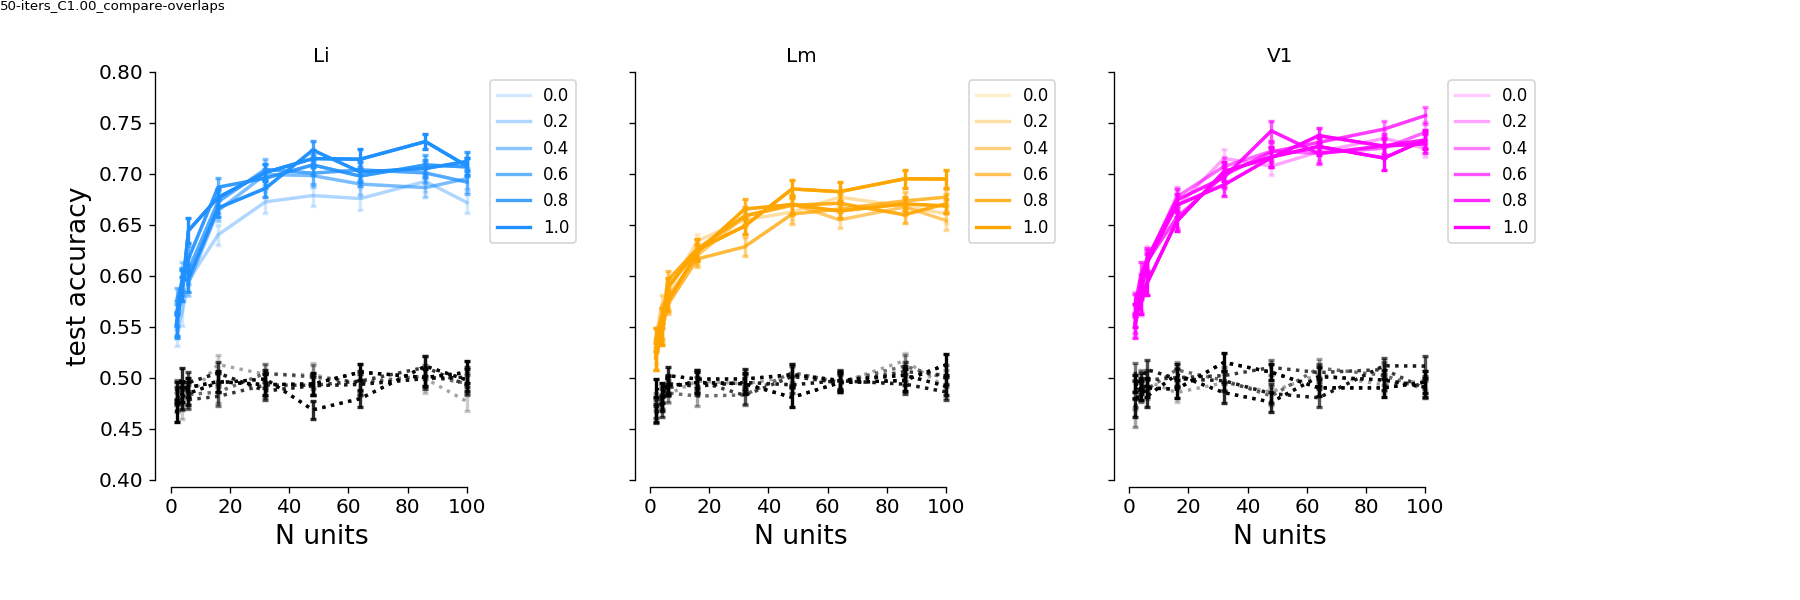

heldout_test_score_compare-overlaps_split-visual-area_C1.00_niter50__dff_resptest-nstds_respthr-0.05


In [1121]:
metric = 'heldout_test_score'
metric_base = 'heldout_test' if metric=='heldout_test_score' else metric

lw = 2
capsize=2

overlap_levels = sorted(ncells_dict.keys())
overlap_alphas = dict((v, a) for v, a in zip(overlap_levels, np.linspace(0.2, 0.99, len(overlap_levels))))

fig, axes = pl.subplots(1, 3, figsize=(15,5), sharex=True, sharey=True, dpi=dpi)
ai = 0
for visual_area, pgroup in pooled.groupby(['visual_area']):
    ax = axes[ai]
    for overlap_l, g in pgroup.groupby(['overlap']):
        mean_scores = g.sort_values(by='n_units')[metric]
        std_scores = g.sort_values(by='n_units')['%s_sem' % metric_base]
        n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
        ax.plot(n_units_per, mean_scores, color=area_colors[visual_area], 
                alpha=overlap_alphas[overlap_l], lw=lw,
                label='%.1f' % (overlap_l))
        ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                    capthick=lw, capsize=capsize, label=None, alpha=overlap_alphas[overlap_l], 
                    lw=lw)
    if ai==0:
        ax.set_ylabel("test accuracy")
    
    ax.legend(bbox_to_anchor=(1.0, 1))
    ax.set_title(visual_area)
    ai += 1
    ax.set_xlabel("N units")

ai=0
for visual_area, pgroup in pooled_chance.groupby(['visual_area']):
    ax = axes[ai]
    for overlap_l, g in pgroup.groupby(['overlap']):
        mean_scores = g.sort_values(by='n_units')[metric]
        std_scores = g.sort_values(by='n_units')['%s_sem' % metric_base]
        n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
        ax.plot(n_units_per, mean_scores, color='k', #area_colors[visual_area], 
                alpha=overlap_alphas[overlap_l], lw=lw, linestyle=':', 
                label=None)
        ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color='k', #area_colors[visual_area], 
                    capthick=lw, capsize=capsize, label=None, alpha=overlap_alphas[overlap_l], 
                    lw=lw, linestyle=':')
        
    ai += 1
    
ax.set_ylim([0.4, 0.8])
sns.despine(trim=True, offset=4)
pl.subplots_adjust(right=0.8, left=0.09, wspace=0.5, bottom=0.2)

analysis_str = '%i-iters_C%.2f_compare-overlaps' % (n_iterations, C_value)
putils.label_figure(fig, analysis_str) 

figname = '%s_compare-overlaps_split-visual-area_C%.2f_niter%i__%s' % (metric, C_value, n_iterations, response_str)
pl.savefig(os.path.join(decoding_dir, '%s.svg' % figname))

print(figname)

## Plot visual areas together, split by overlap_thr

<IPython.core.display.Javascript object>


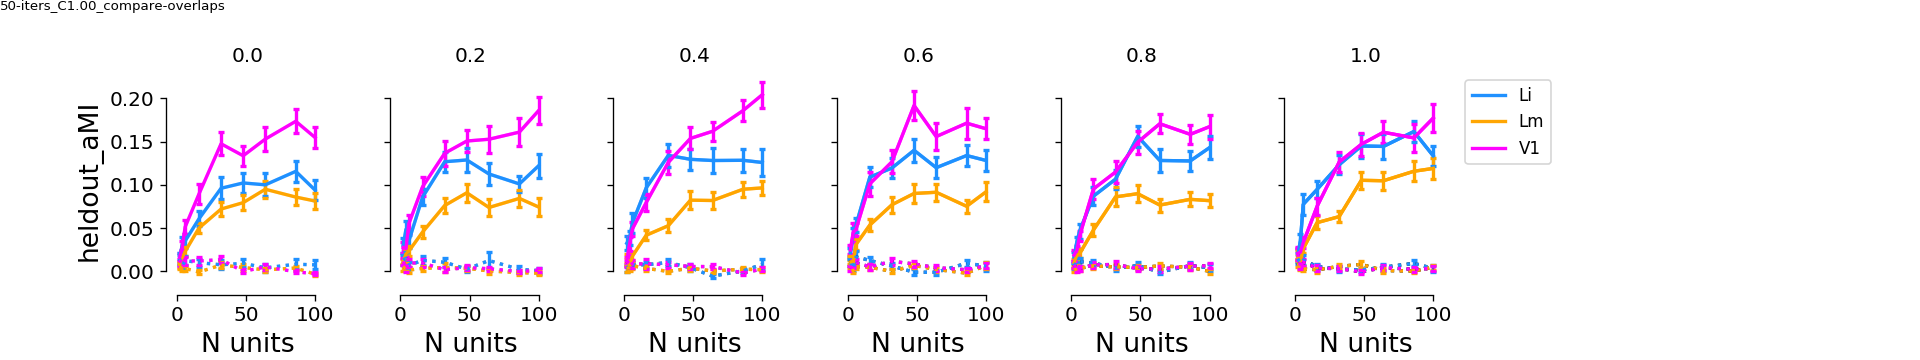

heldout_aMI_compare-overlaps_C1.00_niter50__dff_resptest-nstds_respthr-0.05


In [1125]:
metric = 'heldout_aMI' #'heldout_test_score'
metric_base = 'heldout_test' if metric=='heldout_test_score' else metric

lw = 2
capsize=2

overlap_levels = sorted(ncells_dict.keys())
overlap_alphas = dict((v, a) for v, a in zip(overlap_levels, np.linspace(0.2, 0.99, len(overlap_levels))))


fig, axn = pl.subplots(1, 6, figsize=(16,3), sharex=True, sharey=True, dpi=dpi)
for ci, (overlap_l, pgroup) in enumerate(pooled.groupby(['overlap'])):
    for ai, (visual_area, g) in enumerate(pgroup.groupby(['visual_area'])):
        ax = axn[ci]
        mean_scores = g.sort_values(by='n_units')[metric]
        std_scores = g.sort_values(by='n_units')['%s_sem' % metric_base]
        n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
        ax.plot(n_units_per, mean_scores, color=area_colors[visual_area], 
                alpha=overlap_alphas[overlap_l], lw=lw,
                label='%s' % (visual_area))
        ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                    capthick=lw, capsize=capsize, label=None, alpha=1, #overlap_alphas[overlap_l], 
                    lw=lw)
    ax.set_ylabel('')
    if ci==5:
        ax.legend(bbox_to_anchor=(1.8, 1))
    ax.set_title(overlap_l)
    ax.set_xlabel("N units")
    ax.set_ylabel('classifier accuracy')

for ci, (overlap_l, pgroup) in enumerate(pooled_chance.groupby(['overlap'])):
    for ai, (visual_area, g) in enumerate(pgroup.groupby(['visual_area'])):
        ax = axn[ci]
        mean_scores = g.sort_values(by='n_units')[metric]
        std_scores = g.sort_values(by='n_units')['%s_sem' % metric_base]
        n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
        ax.plot(n_units_per, mean_scores, color='k', #area_colors[visual_area], 
                alpha=overlap_alphas[overlap_l], lw=lw, linestyle=':', 
                label=None)
        ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                    capthick=lw, capsize=capsize, label=None, alpha=1, #overlap_alphas[overlap_l], 
                    lw=lw, linestyle=':')
    if metric=='heldout_test_score':
        ax.set_ylim([0.4, 1.0])
    if ci==0:
        ax.set_ylabel(metric)
    else:
        ax.set_ylabel('')

sns.despine(trim=True, offset=4)
pl.subplots_adjust(right=0.75, left=0.09, wspace=0.5, bottom=0.2, top=0.8)

analysis_str = '%i-iters_C%.2f_compare-overlaps' % (n_iterations, C_value)
putils.label_figure(fig, analysis_str)
   

figname = '%s_compare-overlaps_C%.2f_niter%i__%s' % (metric, C_value, n_iterations, response_str)
pl.savefig(os.path.join(decoding_dir, '%s.svg' % figname))
#pl.savefig(os.path.join(decoding_dir, '%s.png' % figname))

print(figname)

In [1002]:
decoding_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/linear-separability'

<IPython.core.display.Javascript object>


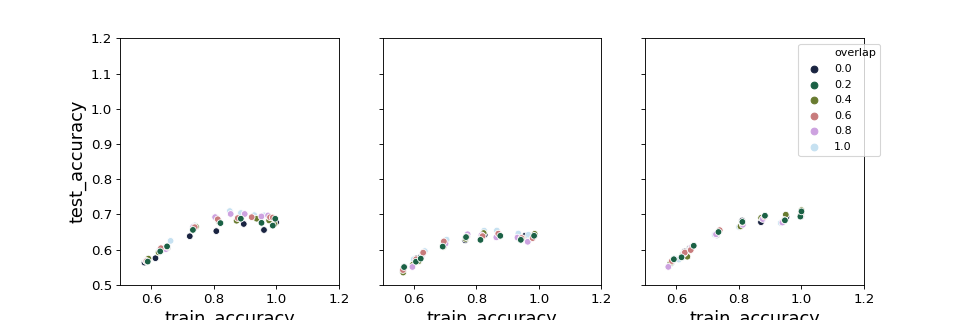

In [1126]:
overlap_palette = sns.color_palette('cubehelix', n_colors=len(overlap_thr_values))

fig, axn = pl.subplots(1,3, figsize=(12,4), sharex=True, sharey=True)

for ai, (ax, (visual_area, g)) in enumerate(zip(axn.flat, pooled.groupby(['visual_area']))):
    
    sns.scatterplot('train_accuracy', 'test_accuracy', hue='overlap', data=g, ax=ax,
                   palette=overlap_palette)
    ax.set_xlim([0.5, 1.2])
    ax.set_ylim([0.5, 1.2])
    #ax.set_aspect('equal')
    
    if ai<2:
        ax.legend_.remove()
        
ax.legend(bbox_to_anchor=(1.1, 1))

# Select 1 overlap_thr and do more fine-grained sampling of NCELLS

In [1141]:
overlap_thr = 0.8
#overlap_thr_values = np.arange(0, 1+overlap_int, overlap_int)

pdf = has_blobs[has_blobs['perc_overlap']>=overlap_thr].copy()
print("Thr: %.2f --------------" % overlap_thr)
print(pdf[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())

NCELLS = [2, 4, 8, 16, 32, 48, 56, 64, 72, 80, 100]


Thr: 0.80 --------------
             datakey  cell
visual_area               
Li               100   100
Lm               185   185
V1               572   572


In [1142]:
print(overlap_thr, NCELLS)
n_iterations=500

(0.8, [2, 4, 8, 16, 32, 48, 56, 64, 72, 80, 100])


In [1143]:
#if load_popdata:
    popdf = []
popdf_chance = []
overlap_thr=0.8
i = 0

print("-------- Overlap: %.2f --------" % overlap_thr)
# Get list of eligible cells from all FOVs
globaldf = filter_rois(has_blobs[has_blobs['datakey'].isin(stim_datakeys)], overlap_thr=overlap_thr) 

for curr_ncells in NCELLS:
    for visual_area, gdf in globaldf.groupby(['visual_area']):
        print("... [%s] popn size: %i" % (visual_area, curr_ncells))

        iter_results=[]; iter_test_results=[];
        iter_results_chance=[]; iter_test_results_chance=[];
        for iteration in np.arange(0, n_iterations):
            # Get random selection of NCELLS for current iter (from global ROI list)
            ncells_t = gdf.shape[0]
            curr_rids = np.array(sorted(gdf['roi'].values.copy()))
            # Random w/ replacement
            rand_ixs = np.array([random.randint(0, ncells_t-1) for x in range(curr_ncells)]) #np.random.shuffle(curr_rids)
            curr_roi_list = curr_rids[rand_ixs] #curr_rids[0:curr_ncells]
            curr_roidf = gdf[gdf['roi'].isin(curr_roi_list)].copy()

            # Make sure equal num trials per condition for all dsets
            # Get fewest total n trials among dsets
            fewest_ntrials = np.min([MEANS[k].shape[0] for k in curr_roidf['datakey'].unique()])
            # Get trial counts per cond for dset w. fewest trials
            min_ntrials = []
            keys_with_few = [k for k in curr_roidf['datakey'].unique() if MEANS[k].shape[0]==fewest_ntrials]
            for k in keys_with_few:
                currd = MEANS[k].sort_values(by='config') #[dgroup['dset_roi']]
                min_ntrials.append(currd.groupby(['config']).count().min().min())
            # set min N trials per condition
            min_ntrials = min(min_ntrials)

            # Get data samples for these cells
            d_list=[]
            for datakey, dgroup in curr_roidf.groupby(['datakey']):
                currd = MEANS[datakey].sort_values(by='config') #[dgroup['dset_roi']]
                min_ntrials = min([min_ntrials, currd.groupby(['config']).count().min().min()])
                # Get subset of trials per cond to match min N trials
                tmp_d=[]
                for cfg, dmat in currd.groupby(['config']):
                    if dmat.shape[0] == min_ntrials:
                        tmp_d.append(dmat)
                    else:
                        tixs = np.arange(0, dmat.shape[0])
                        np.random.shuffle(tixs)
                        currd_subset = dmat.iloc[tixs[0:min_ntrials]].copy()
                        tmp_d.append(currd_subset)
                d_ = pd.concat(tmp_d, axis=0) 
                config_list = d_['config'].values     # Get configs on selected trials
                currd = d_[dgroup['dset_roi']].copy() # Data should only include ROI columns
                currd = currd.reset_index(drop=True)  # Reset trial indices 
                currd.columns = dgroup['roi'].values  # Rename ROI columns to global-rois
                d_list.append(currd)
            curr_data = pd.concat(d_list, axis=1)
            curr_data['config'] = config_list 

            #### Select train/test configs for clf A vs B
            object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
            curr_roi_list = [int(c) for c in curr_data.columns if c != 'config']
            sample_data = curr_data[curr_data['config'].isin(object_configs)]

            #### Equalize df/f across neurons:  Normalize each neuron to have same (zero) mean, (unit) SD across stimuli
            data = sample_data[curr_roi_list]
            zdata = (data - data.mean()) / data.std()

            #### Get labels
            targets = pd.DataFrame(sample_data['config'].copy(), columns=['config'])
            targets['label'] = [sdf.loc[cfg]['morphlevel'][0] for cfg in targets.values]

            stimdf = sdf[sdf['morphlevel'].isin([m0, m100])]
            sizes = sorted(stimdf['size'].unique())

            #### For each transformation, split trials into 80% and 20%
            train_data=[]; test_data=[]; 
            train_labels=[]; test_labels=[]; 
            train_data_chance=[]; test_data_chance=[]; 
            train_labels_chance=[]; test_labels_chance=[]; 
            for sz in sizes: 
                curr_configs = sdf[sdf['size']==sz].index.tolist()
                curr_trials = np.array(targets[targets['config'].isin(curr_configs)].index.tolist())
                xi = zdata.loc[curr_trials]
                yi = targets.loc[curr_trials]['label'].values

                # Split train/test
                train_x, test_x, train_y, test_y = train_test_split(xi, yi, test_size=0.2)
                train_data.append(train_x)
                test_data.append(test_x)
                train_labels.append(train_y)
                test_labels.append(test_y)

            # Aggregate TRAIN/TEST data        
            train_data = np.vstack(train_data)
            train_labels = np.hstack(train_labels)
            test_data = np.vstack(test_data)
            test_labels = np.hstack(test_labels)

            #### DATA - Fit classifier
            svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2')
            scores = cross_validate(svc, train_data, train_labels, cv=5,
                                    scoring=('r2', 'neg_mean_squared_error', 'accuracy'),
                                    return_train_score=True)
            iterdict = dict((s, values.mean()) for s, values in scores.items())

            #### DATA - Test with held-out data
            trained_svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2').fit(train_data, train_labels)
            test_score = trained_svc.score(test_data, test_labels)
            
            #### DATA - Calculate MI
            predicted_labels = trained_svc.predict(test_data)
            mi = skmetrics.mutual_info_score(test_labels, predicted_labels)
            ami = skmetrics.adjusted_mutual_info_score(test_labels, predicted_labels)
            log2_mi = computeMI(test_labels, predicted_labels)
            
            iterdict.update({'heldout_test_score': test_score, 
                             'heldout_MI': mi, 'heldout_aMI': ami, 'heldout_log2MI': log2_mi})
            iter_results.append(pd.DataFrame(iterdict, index=[iteration]))
            
            # ------------------------------------------------------------------
            # Shuffle LABELS to calculate chance level
            train_labels_chance = train_labels.copy()
            np.random.shuffle(train_labels_chance)
            test_labels_chance = test_labels.copy()
            np.random.shuffle(test_labels_chance)

            #### CHANCE - Fit classifier
            svc_chance = LinearSVC(multi_class='ovr', C=C_value, penalty='l2')
            scores_chance = cross_validate(svc, train_data, train_labels_chance, cv=5,
                                    scoring=('r2', 'neg_mean_squared_error', 'accuracy'),
                                    return_train_score=True)
            iterdict_chance = dict((s, values.mean()) for s, values in scores_chance.items())

            # CHANCE - Test with held-out data
            trained_svc_chance = LinearSVC(multi_class='ovr', C=C_value, penalty='l2').fit(train_data, train_labels_chance)
            test_score_chance = trained_svc_chance.score(test_data, test_labels_chance)  
            
            # Chance - Calculate MI
            predicted_labels = trained_svc_chance.predict(test_data)
            mi = skmetrics.mutual_info_score(test_labels, predicted_labels)
            ami = skmetrics.adjusted_mutual_info_score(test_labels, predicted_labels)
            log2_mi = computeMI(test_labels, predicted_labels)
            
            iterdict_chance.update({'heldout_test_score': test_score_chance, 
                                    'heldout_MI': mi, 'heldout_aMI': ami, 'heldout_log2MI': log2_mi})
            iter_results_chance.append(pd.DataFrame(iterdict_chance, index=[iteration]))

        # DATA - get mean across iters
        iter_results = pd.concat(iter_results, axis=0)
        iterdict = dict(iter_results.mean())
        iterdict.update({'n_units': curr_ncells, 
                         'overlap': overlap_thr,
                         'visual_area': visual_area,
                          'heldout_test_sem': spstats.sem(iter_results['heldout_test_score'].values),
                          'heldout_test_std': float(iter_results['heldout_test_score'].std()),
                          'heldout_MI_sem': spstats.sem(iter_results['heldout_MI'].values),
                          'heldout_MI_std': float(iter_results['heldout_MI'].std()),
                          'heldout_aMI_sem': spstats.sem(iter_results['heldout_aMI'].values),
                          'heldout_aMI_std': float(iter_results['heldout_aMI'].std()),
                          'heldout_log2MI_sem': spstats.sem(iter_results['heldout_log2MI'].values),
                          'heldout_log2MI_std': float(iter_results['heldout_log2MI'].std())})
        popdf.append(pd.DataFrame(iterdict, index=[i]))

        # CHANCE - get mean across iters
        iter_results_chance = pd.concat(iter_results_chance, axis=0)
        iterdict_chance = dict(iter_results_chance.mean())
        iterdict_chance.update({'n_units': curr_ncells, 
                                'overlap': overlap_thr,
                                'visual_area': visual_area,
                              'heldout_test_sem': spstats.sem(iter_results_chance['heldout_test_score'].values),
                              'heldout_test_std': float(iter_results_chance['heldout_test_score'].std()),
                              'heldout_MI_sem': spstats.sem(iter_results_chance['heldout_MI'].values),
                              'heldout_MI_std': float(iter_results_chance['heldout_MI'].std()),
                              'heldout_aMI_sem': spstats.sem(iter_results_chance['heldout_aMI'].values),
                              'heldout_aMI_std': float(iter_results_chance['heldout_aMI'].std()),
                              'heldout_log2MI_sem': spstats.sem(iter_results_chance['heldout_log2MI'].values),
                              'heldout_log2MI_std': float(iter_results_chance['heldout_log2MI'].std())})
        popdf_chance.append(pd.DataFrame(iterdict_chance, index=[i]))
        i += 1
results = pd.concat(popdf, axis=0)
results_chance = pd.concat(popdf_chance, axis=0)
print(results.shape, results_chance.shape)
results.head()

-------- Overlap: 0.80 --------
('V1', 572)
('Lm', 185)
('Li', 100)
... [Li] popn size: 2
... [Lm] popn size: 2
... [V1] popn size: 2
... [Li] popn size: 4
... [Lm] popn size: 4
... [V1] popn size: 4
... [Li] popn size: 8
... [Lm] popn size: 8
... [V1] popn size: 8
... [Li] popn size: 16
... [Lm] popn size: 16
... [V1] popn size: 16
... [Li] popn size: 32
... [Lm] popn size: 32
... [V1] popn size: 32
... [Li] popn size: 48
... [Lm] popn size: 48
... [V1] popn size: 48
... [Li] popn size: 56
... [Lm] popn size: 56
... [V1] popn size: 56
... [Li] popn size: 64
... [Lm] popn size: 64
... [V1] popn size: 64
... [Li] popn size: 72
... [Lm] popn size: 72
... [V1] popn size: 72
... [Li] popn size: 80
... [Lm] popn size: 80
... [V1] popn size: 80
... [Li] popn size: 100
... [Lm] popn size: 100
... [V1] popn size: 100
((33, 23), (33, 23))


,fit_time,heldout_MI,heldout_MI_sem,heldout_MI_std,heldout_aMI,heldout_aMI_sem,heldout_aMI_std,heldout_log2MI,heldout_log2MI_sem,heldout_log2MI_std,...,n_units,overlap,score_time,test_accuracy,test_neg_mean_squared_error,test_r2,train_accuracy,train_neg_mean_squared_error,train_r2,visual_area
0,0.003650,0.020443,0.001229,0.027485,0.017418,0.001805,0.040362,0.029493,0.001773,0.039652,...,2,0.8,0.000512,0.561056,-4931.974762,-0.757373,0.581073,-4707.069230,-0.677117,Li
1,0.004448,0.016920,0.001019,0.022787,0.012203,0.001500,0.033538,0.024411,0.001470,0.032875,...,2,0.8,0.000518,0.545976,-5101.414273,-0.817960,0.568528,-4848.021922,-0.727540,Lm
2,0.003726,0.021042,0.001225,0.027384,0.018354,0.001798,0.040195,0.030358,0.001767,0.039507,...,2,0.8,0.000524,0.555620,-4993.058108,-0.779308,0.578534,-4735.594290,-0.687442,V1
3,0.005080,0.037578,0.001785,0.039924,0.042524,0.002622,0.058638,0.054213,0.002576,0.057598,...,4,0.8,0.000526,0.593985,-4561.980516,-0.625561,0.626014,-4202.102657,-0.497224,Li
4,0.005957,0.021228,0.001163,0.026011,0.018572,0.001708,0.038181,0.030626,0.001678,0.037526,...,4,0.8,0.000521,0.562647,-4914.093122,-0.751028,0.599295,-4502.316516,-0.604191,Lm


#### plot MI - overlap_thr fixed

<IPython.core.display.Javascript object>


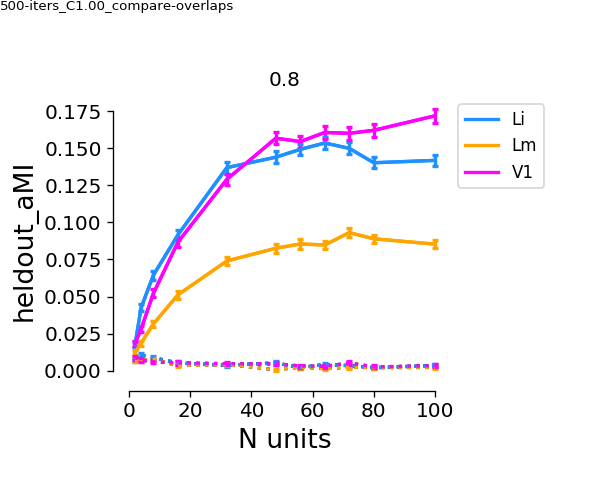

heldout_aMI_lin-sep_overlap0.80_C1.00_niter500__dff_resptest-nstds_respthr-0.05


In [1154]:
metric = 'heldout_aMI' #'heldout_aMI' #'heldout_test_score'
metric_base = 'heldout_test' if metric=='heldout_test_score' else metric

lw = 2
capsize=2

fig, ax = pl.subplots(figsize=(5,4), sharex=True, sharey=True, dpi=dpi)
for ai, (visual_area, g) in enumerate(results.groupby(['visual_area'])):
    mean_scores = g.sort_values(by='n_units')[metric]
    std_scores = g.sort_values(by='n_units')['%s_sem' % metric_base]
    n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
    ax.plot(n_units_per, mean_scores, color=area_colors[visual_area], 
            alpha=overlap_alphas[overlap_l], lw=lw,
            label='%s' % (visual_area))
    ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                capthick=lw, capsize=capsize, label=None, alpha=1, #overlap_alphas[overlap_l], 
                lw=lw)
ax.legend(bbox_to_anchor=(1., 1))
ax.set_title(overlap_thr)
ax.set_xlabel("N units")
ax.set_ylabel(metric)


for ai, (visual_area, g) in enumerate(results_chance.groupby(['visual_area'])):
    mean_scores = g.sort_values(by='n_units')[metric]
    std_scores = g.sort_values(by='n_units')['%s_sem' % metric_base]
    n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
    ax.plot(n_units_per, mean_scores, color='k', #area_colors[visual_area], 
            alpha=overlap_alphas[overlap_l], lw=lw, linestyle=':', 
            label=None)
    ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                capthick=lw, capsize=capsize, label=None, alpha=1, #overlap_alphas[overlap_l], 
                lw=lw, linestyle=':')
if metric=='heldout_test_score':
    ax.set_ylim([0.4, 1.0])
ax.set_ylabel(metric)


sns.despine(trim=True, offset=4)
pl.subplots_adjust(right=0.75, left=0.2, wspace=0.5, bottom=0.2, top=0.8)

analysis_str = '%i-iters_C%.2f_compare-overlaps' % (n_iterations, C_value)
putils.label_figure(fig, analysis_str)
   
figname = '%s_lin-sep_overlap%.2f_C%.2f_niter%i__%s' % (metric, overlap_thr, C_value, n_iterations, response_str)
pl.savefig(os.path.join(decoding_dir, '%s.svg' % figname))
# #pl.savefig(os.path.join(decoding_dir, '%s.png' % figname))

print(figname)

In [1098]:
results.head()

,fit_time,heldout_MI,heldout_MI_sem,heldout_MI_std,heldout_aMI,heldout_aMI_sem,heldout_aMI_std,heldout_log2MI,heldout_log2MI_sem,heldout_log2MI_std,...,n_units,overlap,score_time,test_accuracy,test_neg_mean_squared_error,test_r2,train_accuracy,train_neg_mean_squared_error,train_r2,visual_area
0,0.003581,0.017625,0.002604,0.018415,0.013306,0.003855,0.027258,0.025427,0.003757,0.026568,...,2,0.8,0.000538,0.570314,-4827.954641,-0.720135,0.589152,-4616.292795,-0.644598,Li
1,0.004261,0.019583,0.003882,0.027446,0.015988,0.005720,0.040450,0.028252,0.005600,0.039597,...,2,0.8,0.000520,0.549545,-5061.317730,-0.803790,0.573573,-4791.333748,-0.707420,Lm
2,0.003904,0.016860,0.003525,0.024925,0.012421,0.005144,0.036373,0.024323,0.005085,0.035960,...,2,0.8,0.000546,0.561047,-4932.073987,-0.757595,0.583879,-4675.531498,-0.666071,V1
3,0.005282,0.034933,0.005187,0.036678,0.038543,0.007593,0.053692,0.050398,0.007483,0.052915,...,4,0.8,0.000534,0.596552,-4533.147140,-0.615229,0.627538,-4184.987095,-0.491034,Li
4,0.006122,0.023208,0.003956,0.027977,0.021617,0.005797,0.040994,0.033482,0.005708,0.040362,...,4,0.8,0.000522,0.574038,-4786.113244,-0.705895,0.606195,-4424.792566,-0.576986,Lm


## Compare information metrics

<IPython.core.display.Javascript object>


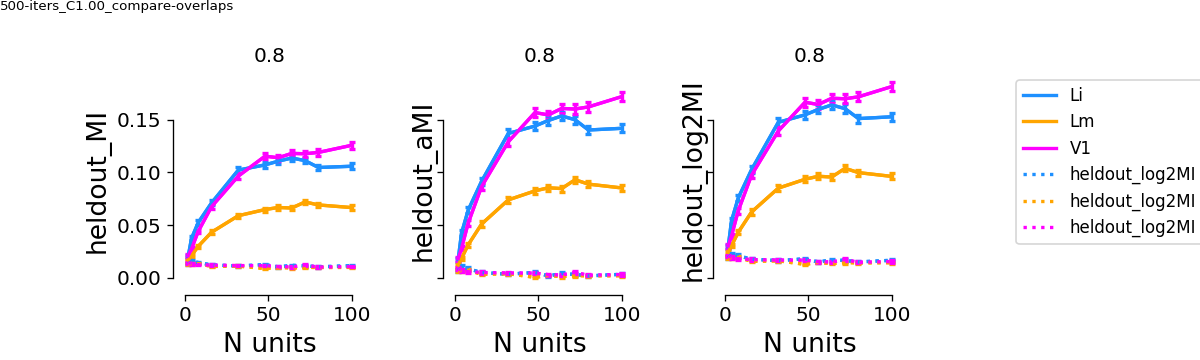

In [1155]:

lw = 2
capsize=2

fig, axn = pl.subplots(1, 3, figsize=(10,3), sharex=True, sharey=True, dpi=dpi)

metric = 'heldout_MI'
for ax, metric in zip(axn.flat, ['heldout_MI', 'heldout_aMI', 'heldout_log2MI']):
    metric_base = 'heldout_test' if metric=='heldout_test_score' else metric
    #ax = axn[0]
    for ai, (visual_area, g) in enumerate(results.groupby(['visual_area'])):
        mean_scores = g.sort_values(by='n_units')[metric]
        std_scores = g.sort_values(by='n_units')['%s_sem' % metric_base]
        n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
        ax.plot(n_units_per, mean_scores, color=area_colors[visual_area], 
                alpha=1, lw=lw, label='%s' % (visual_area))
        ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                    capthick=lw, capsize=capsize, lw=lw, label=None, alpha=1) #overlap_alphas[overlap_l], 
    ax.set_title(overlap_thr)
    ax.set_xlabel("N units")
    ax.set_ylabel(metric)
    
    for ai, (visual_area, g) in enumerate(results_chance.groupby(['visual_area'])):
        mean_scores = g.sort_values(by='n_units')[metric]
        std_scores = g.sort_values(by='n_units')['%s_sem' % metric_base]
        n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
        ax.plot(n_units_per, mean_scores, color=area_colors[visual_area], 
                alpha=1, lw=lw, linestyle=':', label=None)
        ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                    capthick=lw, capsize=capsize, label=None, alpha=1, #overlap_alphas[overlap_l], 
                    lw=lw, linestyle=':')
    #ax.set_ylim([0.4, 1.0])
    ax.set_ylabel(metric)

axn[-1].legend(bbox_to_anchor=(1.6, 1))
sns.despine(trim=True, offset=4)
pl.subplots_adjust(right=0.75, left=0.15, wspace=0.5, bottom=0.2, top=0.8)

analysis_str = '%i-iters_C%.2f_compare-overlaps' % (n_iterations, C_value)
putils.label_figure(fig, analysis_str)
   
# figname = 'lin-sep_overlap%.2f_C%.2f_niter%i__%s' % (overlap_thrC_value, n_iterations, response_str)
# pl.savefig(os.path.join(decoding_dir, '%s.svg' % figname))
# #pl.savefig(os.path.join(decoding_dir, '%s.png' % figname))

# print(figname)

In [1102]:
results.groupby(['visual_area', 'n_units']).mean()

fit_time  heldout_MI  heldout_MI_sem  heldout_MI_std  \
visual_area n_units                                                         
Li          2        0.003581    0.017625        0.002604        0.018415   
            4        0.005282    0.034933        0.005187        0.036678   
            8        0.007254    0.044066        0.006300        0.044550   
            16       0.011590    0.083034        0.006016        0.042542   
            32       0.012882    0.105491        0.010048        0.071051   
            64       0.013936    0.116153        0.009318        0.065889   
            100      0.019367    0.115751        0.009491        0.067110   
Lm          2        0.004261    0.019583        0.003882        0.027446   
            4        0.006122    0.023208        0.003956        0.027977   
            8        0.008209    0.037167        0.005817        0.041135   
            16       0.012848    0.043340        0.005782        0.040885   
            32       0.016152    0.050928        0.005101        0.036069   
            64       0.030028    0.062859        0.005239        0.037045   
            100      0.028118    0.062521        0.007075        0.050027   
V1          2        0.003904    0.016860        0.003525        0.024925   
            4        0.005333    0.024025        0.004958        0.035058   
            8        0.007542    0.045131        0.005278        0.037323   
            16       0.012314    0.060493        0.007342        0.051913   
            32       0.014866    0.087766        0.008008        0.056628   
            64       0.023610    0.140245        0.009934        0.070245   
            100      0.017323    0.118047        0.009299        0.065755   

                     heldout_aMI  heldout_aMI_sem  heldout_aMI_std  \
visual_area n_units                                                  
Li          2           0.013306         0.003855         0.027258   
            4           0.038543         0.007593         0.053692   
            8           0.051870         0.009241         0.065340   
            16          0.108867         0.008813         0.062314   
            32          0.141849         0.014744         0.104258   
            64          0.157240         0.013708         0.096933   
            100         0.156581         0.013931         0.098509   
Lm          2           0.015988         0.005720         0.040450   
            4           0.021617         0.005797         0.040994   
            8           0.041846         0.008507         0.060156   
            16          0.051264         0.008584         0.060695   
            32          0.062215         0.007501         0.053043   
            64          0.079610         0.007660         0.054168   
            100         0.079048         0.010369         0.073323   
V1          2           0.012421         0.005144         0.036373   
            4           0.022685         0.007271         0.051414   
            8           0.053557         0.007724         0.054617   
            16          0.076196         0.010770         0.076158   
            32          0.116140         0.011715         0.082836   
            64          0.193196         0.014560         0.102956   
            100         0.160508         0.013622         0.096325   

                     heldout_log2MI  heldout_log2MI_sem  heldout_log2MI_std  \
visual_area n_units                                                           
Li          2              0.025427            0.003757            0.026568   
            4              0.050398            0.007483            0.052915   
            8              0.063574            0.009089            0.064271   
            16             0.119792            0.008680            0.061375   
            32             0.152191            0.014496            0.102505   
            64             0.167573            0.013443            0.095057   
      

In [ ]:
luminance_dir = os.path.join(aggregate_dir, 'luminance-analysis')

overlaps_datafile = os.path.join(luminance_dir, 'overlaps-all-RFs.pkl')
assert os.path.exists(overlaps_datafile), "OVERLAPS NOT FOUND."
with open(overlaps_datafile, 'rb') as f:
    overlaprois = pkl.load(f)



# Test generalization

In [ ]:
exp = util.Objects(animalid, session, fov, traceid=traceid, rootdir=rootdir)
# Get stimulus conditions
sdf = exp.get_stimuli()
sdf = reformat_morph_values(sdf)
sizes = np.array(sorted(sdf['size'].unique()))
morphs = np.array(sorted(sdf['morphlevel'].unique()))

In [1156]:
overlap_thr=0.8
print("-------- Overlap: %.2f --------" % overlap_thr)
# Get list of eligible cells from all FOVs
globaldf = filter_rois(has_blobs[has_blobs['datakey'].isin(stim_datakeys)], overlap_thr=overlap_thr) 


-------- Overlap: 0.80 --------
('V1', 572)
('Lm', 185)
('Li', 100)


In [1230]:
from sklearn.model_selection import StratifiedKFold

In [1372]:
overlap_thr = 0.8
#overlap_thr_values = np.arange(0, 1+overlap_int, overlap_int)

pdf = has_blobs[has_blobs['perc_overlap']>=overlap_thr].copy()
print("Thr: %.2f --------------" % overlap_thr)
print(pdf[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())

#NCELLS = [2, 4, 8, 16, 32, 48, 56, 64, 72, 80, 100]
NCELLS = [2, 4, 8, 16, 32, 64, 82, 100]

print(overlap_thr, NCELLS)
n_iterations=500

Thr: 0.80 --------------
             datakey  cell
visual_area               
Li               100   100
Lm               185   185
V1               572   572
(0.8, [2, 4, 8, 16, 32, 64, 82, 100])


In [1373]:
#if load_popdata:
    
res_list=[]
i = 0
print("-------- Overlap: %.2f --------" % overlap_thr)
# Get list of eligible cells from all FOVs
globaldf = filter_rois(has_blobs[has_blobs['datakey'].isin(stim_datakeys)], overlap_thr=overlap_thr) 

for curr_ncells in NCELLS:
    for visual_area, gdf in globaldf.groupby(['visual_area']):
        print("... [%s] popn size: %i" % (visual_area, curr_ncells))
        r_list=[]
        for iteration in np.arange(0, n_iterations):
            # Get random selection of NCELLS for current iter (from global ROI list)
            ncells_t = gdf.shape[0]
            curr_rids = np.array(sorted(gdf['roi'].values.copy()))

            # Random w/ replacement
            rand_ixs = np.array([random.randint(0, ncells_t-1) for x in range(curr_ncells)]) #np.random.shuffle(curr_rids)
            curr_roi_list = curr_rids[rand_ixs] #curr_rids[0:curr_ncells]
            curr_roidf = gdf[gdf['roi'].isin(curr_roi_list)].copy() # Get rois/datasets that correspond to these global rids

            # Make sure equal num trials per condition for all dsets
            if not exact_trials:
                # Get fewest total n trials among dsets
                fewest_ntrials = np.min([MEANS[k].shape[0] for k in curr_roidf['datakey'].unique()])
                # Get trial counts per cond for dset w. fewest trials
                min_ntrials = []
                keys_with_few = [k for k in curr_roidf['datakey'].unique() if MEANS[k].shape[0]==fewest_ntrials]
                for k in keys_with_few:
                    currd = MEANS[k].sort_values(by='config') #[dgroup['dset_roi']]
                    min_ntrials.append(currd.groupby(['config']).count().min().min())
                # set min N trials per condition
                min_ntrials = min(min_ntrials)

            # For each cell, get is particular trials by loading the dataset it came from
            d_list=[]
            for datakey, dgroup in curr_roidf.groupby(['datakey']):
                currd = MEANS[datakey].sort_values(by='config') #[dgroup['dset_roi']]
                min_ntrials = min([min_ntrials, currd.groupby(['config']).count().min().min()])
                if exact_trials:
                    tmp_d = currd.copy()
                else:
                    # get subset of trials per cond to match min N trials
                    tmp_d=[]
                    for cfg, dmat in currd.groupby(['config']):
                        if dmat.shape[0] == min_ntrials:
                            tmp_d.append(dmat)
                        else:
                            tixs = np.arange(0, dmat.shape[0])
                            np.random.shuffle(tixs)
                            currd_subset = dmat.iloc[tixs[0:min_ntrials]].copy()
                            tmp_d.append(currd_subset)
                    d_ = pd.concat(tmp_d, axis=0)     # Get current cell's trials
                config_list = d_['config'].values     # Get configs on selected trials
                currd = d_[dgroup['dset_roi']].copy() # Data should only include ROI columns
                currd = currd.reset_index(drop=True)  # Reset trial indices 
                currd.columns = dgroup['roi'].values  # Rename ROI columns to global-rois
                d_list.append(currd)
            #curr_data = pd.concat(d_list, axis=1)
            #curr_data['config'] = config_list 
            sample_data = pd.concat(d_list, axis=1)
            sample_labels = config_list

            #### Select train/test configs for clf A vs B
            # object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
            curr_roi_list = [int(c) for c in curr_data.columns if c != 'config']
            #sample_data = curr_data[curr_data['config'].isin(object_configs)]

            #-----------------
            stimdf = sdf.copy()
            tested_sizes = sorted(sdf['size'].unique())
            tested_morphs = sorted(sdf['morphlevel'].unique())

            #% Specify train/test conditions:     
            class_name = 'morphlevel'
            class_types = [0, 106]
            restrict_transform = True
            constant_transform = 'size'

            # C = 1e3
            m0 = 0
            m100 = 106

            # Go thru all training sizes, then test on non-trained sizes
            for train_transform in tested_sizes:
                # Get train configs
                train_configs = stimdf[((stimdf[class_name].isin(class_types))\
                                        & (stimdf[constant_transform]==train_transform))].index.tolist()

                # Get corresponding indices into data array
                train_ixs = [i for i, l in enumerate(sample_labels) if l in train_configs]

                # Get data and labels
                X = sample_data.iloc[train_ixs].values #[train_configs]
                y = np.array([stimdf[class_name][c] for c in sample_labels[train_ixs]])

                train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2)

                
                # Select generalization-test set
                untrained_class_types = [c for c in stimdf[class_name].unique() if c not in class_types]
                test_configs = stimdf[( (stimdf[constant_transform]!=train_transform)\
                                       & (stimdf[class_name].isin(class_types)) )].index.tolist()
                test_ixs = [i for i, l in enumerate(sample_labels) if l in test_configs]
                X_test = sample_data.iloc[test_ixs].values
                y_test_labels = sample_labels[test_ixs]
                test_transforms = stimdf[stimdf[constant_transform]!=train_transform][constant_transform].unique()

                #% Train/validation split
                n_splits = 5 #len(X)
                kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0) #KFold(n_splits=n_splits)
                kf.get_n_splits(train_x) #(X)

                # Do K-fold CV for current stimulus configs
                scores=[]
                test_scores = dict((tv, []) for tv in tested_sizes)
                for train_index, validate_index in kf.split(train_x, train_y): #(X, y): #kf.split(X):

                    # Get current train/validate split data
#                     X_train, X_validate = X[train_index], X[validate_index]
#                     y_train, y_validate = y[train_index], y[validate_index]
                    X_train, X_validate = train_x[train_index], train_x[validate_index]
                    y_train, y_validate = train_y[train_index], train_y[validate_index]
        
                    scaler = preprocessing.StandardScaler().fit(X_train)
                    X_train_transformed = scaler.transform(X_train)

                    # Fit SVM
                    trained_svc = LinearSVC(multi_class='ovr', C=C_value).fit(X_train_transformed, y_train)

                    # Validate with held-out data
                    X_validate_transformed = scaler.transform(X_validate)
                    curr_score = trained_svc.score(X_validate_transformed, y_validate)  
                    y_pred = trained_svc.predict(X_validate_transformed)

                    # Add current fold score
                    test_scores[train_transform].append(curr_score)

                    # Test (generalization) to each size and update test scores
                    for test_transform in sorted(test_transforms):
                        curr_test_ixs = [i for i, tl in enumerate(y_test_labels)\
                                         if stimdf[constant_transform][tl]==test_transform]

                        X_test_transformed = scaler.transform(X_test[curr_test_ixs, :])
                        y_test_curr_labels = [stimdf['morphlevel'][tc] for tc in y_test_labels[curr_test_ixs]]
                        curr_score_test = trained_svc.score(X_test_transformed, y_test_curr_labels)
                        test_scores[test_transform].append( curr_score_test )

                test_df = pd.DataFrame(dict((k, np.mean(v)) for k, v in test_scores.items()), index=[train_transform])
                test_df['iteration'] = iteration
                test_df['train_cond'] = train_transform
                r_list.append(test_df)
        iter_res = pd.concat(r_list, axis=0)
        #iter_res = res.groupby(['train_cond', 'iteration']).mean().reset_index()
        iter_res['visual_area'] = [visual_area for _ in np.arange(0, len(iter_res))]
        iter_res['n_cells'] = [curr_ncells for _ in np.arange(0, len(iter_res))]
        res_list.append(iter_res)
        

print(len(res_list))

res = pd.concat(res_list)
print(res.shape)

-------- Overlap: 0.80 --------
('V1', 572)
('Lm', 185)
('Li', 100)
... [Li] popn size: 2
... [Lm] popn size: 2
... [V1] popn size: 2
... [Li] popn size: 4
... [Lm] popn size: 4
... [V1] popn size: 4
... [Li] popn size: 8
... [Lm] popn size: 8
... [V1] popn size: 8
... [Li] popn size: 16
... [Lm] popn size: 16
... [V1] popn size: 16
... [Li] popn size: 32
... [Lm] popn size: 32
... [V1] popn size: 32
... [Li] popn size: 64
... [Lm] popn size: 64
... [V1] popn size: 64
... [Li] popn size: 82
... [Lm] popn size: 82
... [V1] popn size: 82
... [Li] popn size: 100
... [Lm] popn size: 100
... [V1] popn size: 100


In [1456]:
n_iterations = 3

In [1460]:
i=0
r_list=[]
for iteration in np.arange(0, n_iterations):
    # Get random selection of NCELLS for current iter (from global ROI list)
    ncells_t = gdf.shape[0]
    curr_rids = np.array(sorted(gdf['roi'].values.copy()))

    # Random w/ replacement
    rand_ixs = np.array([random.randint(0, ncells_t-1) for x in range(curr_ncells)]) #np.random.shuffle(curr_rids)
    curr_roi_list = curr_rids[rand_ixs] #curr_rids[0:curr_ncells]
    curr_roidf = gdf[gdf['roi'].isin(curr_roi_list)].copy() # Get rois/datasets that correspond to these global rids

    # Make sure equal num trials per condition for all dsets
    # if not exact_trials:
    # Get fewest total n trials among dsets
    fewest_ntrials = np.min([MEANS[k].shape[0] for k in curr_roidf['datakey'].unique()])
    # Get trial counts per cond for dset w. fewest trials
    min_ntrials = []
    keys_with_few = [k for k in curr_roidf['datakey'].unique() if MEANS[k].shape[0]==fewest_ntrials]
    for k in keys_with_few:
        currd = MEANS[k].sort_values(by='config') #[dgroup['dset_roi']]
        min_ntrials.append(currd.groupby(['config']).count().min().min())
    # set min N trials per condition
    min_ntrials = min(min_ntrials)

    # For each cell, get is particular trials by loading the dataset it came from
    d_list=[]
    for datakey, dgroup in curr_roidf.groupby(['datakey']):
        currd = MEANS[datakey].sort_values(by='config') #[dgroup['dset_roi']]
        min_ntrials = min([min_ntrials, currd.groupby(['config']).count().min().min()])
        #if exact_trials:
        #    tmp_d = currd.copy()
        #else:
        # Get subset of trials per cond to match min N trials
        tmp_d=[]
        for cfg, dmat in currd.groupby(['config']):
            if dmat.shape[0] == min_ntrials:
                tmp_d.append(dmat)
            else:
                tixs = np.arange(0, dmat.shape[0])
                np.random.shuffle(tixs)
                currd_subset = dmat.iloc[tixs[0:min_ntrials]].copy()
                tmp_d.append(currd_subset)
        d_ = pd.concat(tmp_d, axis=0)     # Get current cell's trials
        config_list = d_['config'].values     # Get configs on selected trials
        currd = d_[dgroup['dset_roi']].copy() # Data should only include ROI columns
        currd = currd.reset_index(drop=True)  # Reset trial indices 
        currd.columns = dgroup['roi'].values  # Rename ROI columns to global-rois
        d_list.append(currd)
    #curr_data = pd.concat(d_list, axis=1)
    #curr_data['config'] = config_list 
    sample_data = pd.concat(d_list, axis=1)
    sample_labels = config_list

    #### Select train/test configs for clf A vs B
    # object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
    curr_roi_list = [int(c) for c in curr_data.columns if c != 'config']
    #sample_data = curr_data[curr_data['config'].isin(object_configs)]

    #-----------------
    stimdf = sdf.copy()
    tested_sizes = sorted(sdf['size'].unique())
    tested_morphs = sorted(sdf['morphlevel'].unique())

    #% Specify train/test conditions:     
    class_name = 'morphlevel'
    class_types = [0, 106]
    restrict_transform = True
    constant_transform = 'size'

    # C = 1e3
    m0 = 0
    m100 = 106

    # Go thru all training sizes, then test on non-trained sizes
    for train_transform in tested_sizes:
        # Get train configs
        train_configs = stimdf[((stimdf[class_name].isin(class_types))\
                                & (stimdf[constant_transform]==train_transform))].index.tolist()

        # Get corresponding indices into data array
        train_ixs = [i for i, l in enumerate(sample_labels) if l in train_configs]

        # Get data and labels
        X = sample_data.iloc[train_ixs].values #[train_configs]
        y = np.array([stimdf[class_name][c] for c in sample_labels[train_ixs]])
        
        # Save test set for train transform
        train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2)

        # Select generalization-test set
        untrained_class_types = [c for c in stimdf[class_name].unique() if c not in class_types]
        test_configs = stimdf[( (stimdf[constant_transform]!=train_transform)\
                               & (stimdf[class_name].isin(class_types)) )].index.tolist()
        test_ixs = [i for i, l in enumerate(sample_labels) if l in test_configs]
        X_test = sample_data.iloc[test_ixs].values
        y_test_labels = sample_labels[test_ixs]
        test_transforms = stimdf[stimdf[constant_transform]!=train_transform][constant_transform].unique()

        #% Train/validation split
        n_splits = 3 #len(X)
        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0) #KFold(n_splits=n_splits)
        kf.get_n_splits(train_x) #(X)

        test_scores = dict((tv, []) for tv in tested_sizes)
        
        # Do K-fold CV for current stimulus configs
        cv_scores=[]
        for train_index, validate_index in kf.split(train_x, train_y): #(X, y): #kf.split(X):
            # Get current train/validate split data
#                     X_train, X_validate = X[train_index], X[validate_index]
#                     y_train, y_validate = y[train_index], y[validate_index]
            X_train, X_validate = train_x[train_index], train_x[validate_index]
            y_train, y_validate = train_y[train_index], train_y[validate_index]

            scaler = preprocessing.StandardScaler().fit(X_train)
            X_train_transformed = scaler.transform(X_train)

            # Fit SVM
            trained_svc = LinearSVC(multi_class='ovr', C=C_value).fit(X_train_transformed, y_train)

            # Validate with held-out data
            X_validate_transformed = scaler.transform(X_validate)
            cv_score = trained_svc.score(X_validate_transformed, y_validate)  
            #y_pred = trained_svc.predict(X_validate_transformed)
            cv_scores.append(cv_score)

        # Save CV and test scores
        mean_cv_score = np.mean(cv_scores)
        
        # Train clf on all (train) data
        trained_svc = LinearSVC(multi_class='ovr', C=C_value).fit(train_x, train_y)
        heldout_train_score = trained_svc.score(test_x, test_y)  
        
        # test_scores[train_transform].append(curr_score)

        # Test (generalization) to each size and update test scores
        for test_transform in sorted(test_transforms):
            curr_test_ixs = [i for i, tl in enumerate(y_test_labels)\
                             if stimdf[constant_transform][tl]==test_transform]

            X_test_transformed = scaler.transform(X_test[curr_test_ixs, :])
            y_test_curr_labels = [stimdf['morphlevel'][tc] for tc in y_test_labels[curr_test_ixs]]
            curr_score_test = trained_svc.score(X_test_transformed, y_test_curr_labels)
            test_scores[test_transform].append( curr_score_test )


        test_scores[train_transform] = heldout_train_score
        tdf = pd.concat([pd.DataFrame({'test_cond': k, 'test_score': np.mean(v)}, index=[i]) \
                   for k, v in test_scores.items()], axis=0)
        tdf['cv_score'] = [mean_cv_score for _ in np.arange(0, len(tdf))]
        tdf['iteration'] = [iteration for _ in np.arange(0, len(tdf))]
        tdf['train_cond'] = [train_transform for _ in np.arange(0, len(tdf))]
        i+=1

        #test_df = pd.DataFrame(dict((k, np.mean(v)) for k, v in test_scores.items()), index=[train_transform])
        #test_df['iteration'] = iteration
        #test_df['train_cond'] = train_transform
        r_list.append(tdf.reset_index(drop=True))

In [1461]:
print(len(r))
r = pd.concat(r_list)
print(r.shape)
r.head()

75
(75, 5)


,test_cond,test_score,cv_score,iteration,train_cond
0,40.0,0.448276,0.476389,0,10.0
1,10.0,0.833333,0.476389,0,10.0
2,20.0,0.517241,0.476389,0,10.0
3,50.0,0.517241,0.476389,0,10.0
4,30.0,0.431034,0.476389,0,10.0


In [1464]:
r.groupby(['train_cond', 'test_cond']).mean()

test_score  cv_score  iteration
train_cond test_cond                                 
10.0       10.0         0.583333  0.702579          1
           20.0         0.557471  0.702579          1
           30.0         0.419540  0.702579          1
           40.0         0.500000  0.702579          1
           50.0         0.534483  0.702579          1
20.0       10.0         0.551724  0.686177          1
           20.0         0.777778  0.686177          1
           30.0         0.839080  0.686177          1
           40.0         0.752874  0.686177          1
           50.0         0.775862  0.686177          1
30.0       10.0         0.471264  0.870370          1
           20.0         0.758621  0.870370          1
           30.0         0.944444  0.870370          1
           40.0         0.752874  0.870370          1
           50.0         0.718391  0.870370          1
40.0       10.0         0.511494  0.796759          1
           20.0         0.683908  0.796759          1
           30.0         0.804598  0.796759          1
           40.0         0.861111  0.796759          1
           50.0         0.908046  0.796759          1
50.0       10.0         0.459770  0.812500          1
           20.0         0.666667  0.812500          1
           30.0         0.793103  0.812500          1
           40.0         0.816092  0.812500          1
           50.0         0.916667  0.812500          1

In [1385]:
res.groupby(['train_cond']).count()

,10.0,20.0,30.0,40.0,50.0,iteration,visual_area,n_cells
train_cond,,,,,,,,
10.0,12000,12000,12000,12000,12000,12000,12000,12000
20.0,12000,12000,12000,12000,12000,12000,12000,12000
30.0,12000,12000,12000,12000,12000,12000,12000,12000
40.0,12000,12000,12000,12000,12000,12000,12000,12000
50.0,12000,12000,12000,12000,12000,12000,12000,12000


In [1386]:
res.groupby(['visual_area', 'train_cond', 'iteration', 'n_cells']).mean()

10.0      20.0      30.0  \
visual_area train_cond iteration n_cells                                 
Li          10.0       0         2        0.566667  0.606897  0.513793   
                                 4        0.556667  0.548276  0.610345   
                                 8        0.620000  0.644828  0.582759   
                                 16       0.593333  0.557692  0.584615   
                                 32       0.530000  0.589655  0.620690   
                                 64       0.573333  0.582759  0.510345   
                                 82       0.653333  0.615385  0.576923   
                                 100      0.623333  0.657692  0.634615   
                       1         2        0.703333  0.603448  0.693103   
                                 4        0.643333  0.520690  0.517241   
                                 8        0.673333  0.668966  0.662069   
                                 16       0.540000  0.538462  0.538462   
                                 32       0.640000  0.655172  0.658621   
                                 64       0.560000  0.592308  0.626923   
                                 82       0.520000  0.469231  0.588462   
                                 100      0.640000  0.630769  0.600000   
                       2         2        0.526667  0.562069  0.627586   
                                 4        0.606667  0.551724  0.579310   
                                 8        0.643333  0.600000  0.613793   
                                 16       0.533333  0.548276  0.572414   
                                 32       0.600000  0.565517  0.710345   
                                 64       0.580000  0.615385  0.561538   
                                 82       0.683333  0.615385  0.692308   
                                 100      0.803333  0.657692  0.573077   
                       3         2        0.650000  0.631034  0.620690   
                                 4        0.483333  0.586207  0.496552   
                                 8        0.623333  0.662069  0.603448   
                                 16       0.556667  0.557692  0.546154   
                                 32       0.640000  0.576923  0.623077   
                                 64       0.556667  0.561538  0.534615   
...                                            ...       ...       ...   
V1          50.0       496       8        0.486667  0.600000  0.666667   
                                 16       0.541379  0.610345  0.613793   
                                 32       0.496552  0.610345  0.668966   
                                 64       0.489655  0.555172  0.655172   
                                 82       0.537931  0.586207  0.624138   
                                 100      0.513793  0.527586  0.686207   
                       497       2        0.530000  0.496667  0.556667   
                                 4        0.493333  0.486667  0.680000   
                                 8        0.516667  0.530000  0.630000   
                                 16       0.562069  0.620690  0.644828   
                                 32       0.586207  0.548276  0.668966   
                                 64       0.362069  0.710345  0.796552   
                                 82       0.420690  0.565517  0.644828   
                                 100      0.479310  0.579310  0.675862   
                       498       2        0.520000  0.613333  0.683333   
                                 4        0.531034  0.448276  0.679310   
                                 8        0.558621  0.572414  0.644828   
                                 16       0.493103  0.586207  0.600000   
                                 32       0.500000  0.610345  0.675862   
                                 64       0.448276  0.682759  0.782759   
                                 82       0.531034  0.700000  0.737931   
                                 100      0.475862

In [1387]:
meandf = res.groupby(['visual_area', 'n_cells', 'train_cond']).mean().reset_index()

meandf[meandf['n_cells']==100]

,visual_area,n_cells,train_cond,10.0,20.0,30.0,40.0,50.0,iteration
35,Li,100,10.0,0.622267,0.597957,0.619528,0.578224,0.520182,249.5
36,Li,100,20.0,0.618292,0.670720,0.685196,0.652398,0.638937,249.5
37,Li,100,30.0,0.612711,0.666957,0.751507,0.740051,0.669888,249.5
38,Li,100,40.0,0.603901,0.634257,0.739493,0.768947,0.745054,249.5
39,Li,100,50.0,0.557340,0.626703,0.679067,0.737358,0.701400,249.5
75,Lm,100,10.0,0.522480,0.536097,0.556034,0.547131,0.569414,249.5
76,Lm,100,20.0,0.525862,0.569893,0.643297,0.572766,0.528366,249.5
77,Lm,100,30.0,0.537034,0.629359,0.704220,0.669138,0.644103,249.5
78,Lm,100,40.0,0.509145,0.575434,0.673779,0.707907,0.750166,249.5
79,Lm,100,50.0,0.518759,0.576069,0.627724,0.695966,0.813753,249.5


<IPython.core.display.Javascript object>


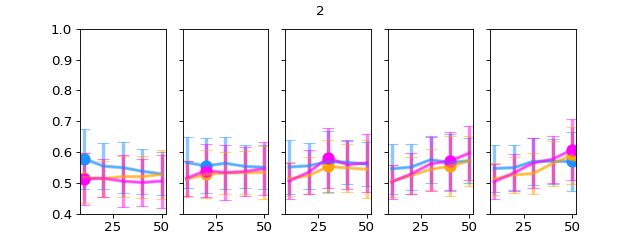

<IPython.core.display.Javascript object>


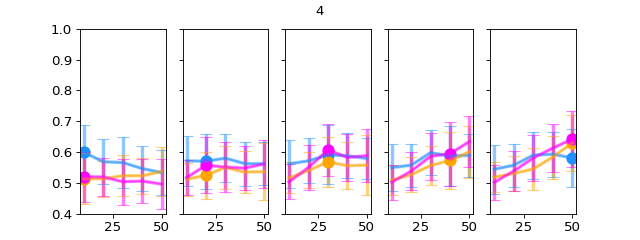

<IPython.core.display.Javascript object>


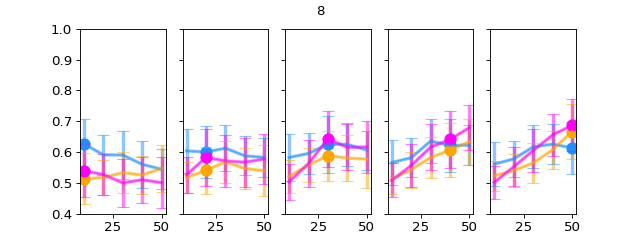

<IPython.core.display.Javascript object>


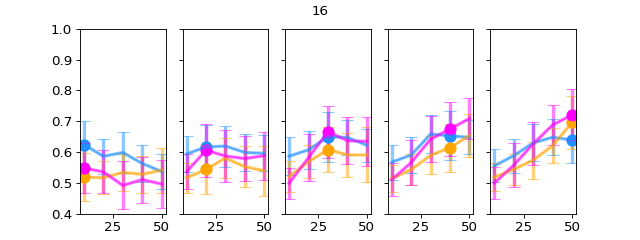

<IPython.core.display.Javascript object>


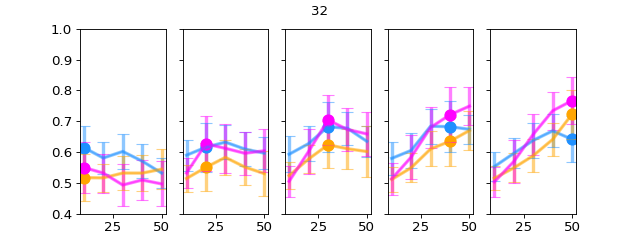

<IPython.core.display.Javascript object>


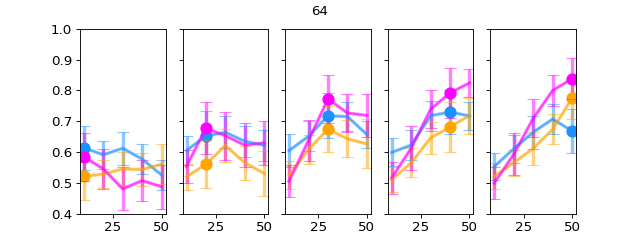

<IPython.core.display.Javascript object>


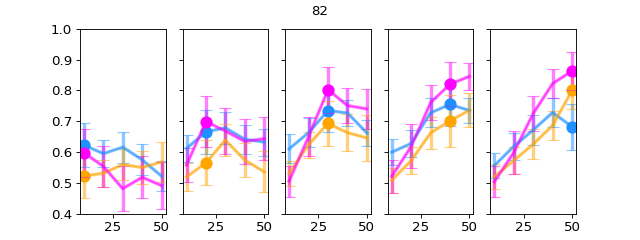

<IPython.core.display.Javascript object>


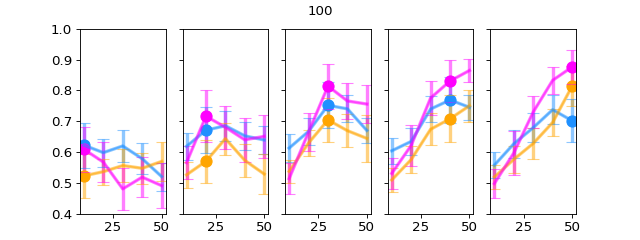

In [1424]:
for ncells in NCELLS:

    fig, axn = pl.subplots(1, 5, figsize=(8,3), sharey=True, sharex=True)

    for ax, (tcond, traindf) in zip(axn.flat, (res[res['n_cells']==ncells].groupby(['train_cond']))):
        for visual_area, v_df in traindf.groupby(['visual_area']):
            means = v_df.mean()[tested_sizes]
            # print(means.values)
            ax.plot(tested_sizes, means.values, 
                   color=area_colors[visual_area], alpha=0.5)

            ax.errorbar(tested_sizes, means.values, yerr=v_df[tested_sizes].std(), capsize=5, lw=3,
                   color=area_colors[visual_area], alpha=0.5)
            ax.set_ylim([0.4, 1])

            ax.plot(tcond, means[tcond], 'o', color=area_colors[visual_area], markersize=10)
    fig.suptitle(ncells)

In [1407]:
spstats.sem(v_df[tested_sizes])

array([ 0.00213105,  0.00313161,  0.00237023,  0.00194066,  0.00244481])

In [1422]:
fig, axn = pl.subplots(1, 5, figsize=(8,3), sharey=True, sharex=True)

    for ax, (tcond, traindf) in zip(axn.flat, (res[res['n_cells']==ncells].groupby(['train_cond']))):
        for visual_area, v_df in traindf.groupby(['visual_area']):
            means = v_df.mean()[tested_sizes]
            # print(means.values)
            ax.plot(tested_sizes, means.values, 
                   color=area_colors[visual_area], alpha=0.5)

            ax.errorbar(tested_sizes, means.values, yerr=v_df[tested_sizes].std(), capsize=5, lw=3,
                   color=area_colors[visual_area], alpha=0.5)
            ax.set_ylim([0.4, 1])

            ax.plot(tcond, means[tcond], 'o', color=area_colors[visual_area], markersize=10)
    fig.suptitle(ncells)

10.0    0.002131
20.0    0.003132
30.0    0.002370
40.0    0.001941
50.0    0.002445
dtype: float64

In [1429]:
res[res['train_cond']==50].groupby(['n_cells', 'visual_area']).mean()

10.0      20.0      30.0      40.0      50.0  \
n_cells visual_area                                                     
2       Li           0.546525  0.549205  0.569532  0.569921  0.569234   
        Lm           0.512468  0.525767  0.530065  0.563154  0.589091   
        V1           0.503806  0.532294  0.564314  0.576856  0.607513   
4       Li           0.544108  0.557034  0.589919  0.592929  0.580822   
        Lm           0.518287  0.530510  0.544892  0.583309  0.629044   
        V1           0.501355  0.538276  0.580536  0.612316  0.641693   
8       Li           0.560511  0.577638  0.616656  0.625477  0.613333   
        Lm           0.522712  0.539898  0.564462  0.607050  0.666387   
        V1           0.501614  0.552315  0.604851  0.655354  0.686720   
16      Li           0.555031  0.588138  0.629946  0.647784  0.638853   
        Lm           0.518510  0.543662  0.573759  0.620745  0.696120   
        V1           0.498886  0.557640  0.626551  0.688114  0.720453   
32      Li           0.552726  0.595707  0.637820  0.668612  0.641007   
        Lm           0.514724  0.548366  0.588152  0.640848  0.723000   
        V1           0.503020  0.569164  0.657378  0.733877  0.766887   
64      Li           0.553211  0.610473  0.664343  0.706896  0.668220   
        Lm           0.520903  0.565297  0.611552  0.673848  0.775020   
        V1           0.499428  0.593021  0.709510  0.799683  0.837853   
82      Li           0.555919  0.618285  0.671734  0.728216  0.681753   
        Lm           0.519379  0.572359  0.625434  0.686593  0.799753   
        V1           0.503545  0.598600  0.725131  0.822317  0.862940   
100     Li           0.557340  0.626703  0.679067  0.737358  0.701400   
        Lm           0.518759  0.576069  0.627724  0.695966  0.813753   
        V1           0.497559  0.596938  0.729876  0.832759  0.876147   

                     iteration  train_cond  
n_cells visual_area                         
2       Li               249.5        50.0  
        Lm               249.5        50.0  
        V1               249.5        50.0  
4       Li               249.5        50.0  
        Lm               249.5        50.0  
        V1               249.5        50.0  
8       Li               249.5        50.0  
        Lm               249.5        50.0  
        V1               249.5        50.0  
16      Li               249.5        50.0  
        Lm               249.5        50.0  
        V1               249.5        50.0  
32      Li               249.5        50.0  
        Lm               249.5        50.0  
        V1               249.5        50.0  
64      Li               249.5        50.0  
        Lm               249.5        50.0  
        V1               249.5        50.0  
82      Li               249.5        50.0  
        Lm               249.5        50.0  
        V1               249.5        50.0  
100     Li               249.5        50.0  
        Lm               249.5        50.0  
        V1               249.5        50.0

In [1431]:
curr_mean = res[res['train_cond']==50].groupby(['n_cells', 'visual_area']).mean().reset_index()
curr_mean

,n_cells,visual_area,10.0,20.0,30.0,40.0,50.0,iteration,train_cond
0,2,Li,0.546525,0.549205,0.569532,0.569921,0.569234,249.5,50.0
1,2,Lm,0.512468,0.525767,0.530065,0.563154,0.589091,249.5,50.0
2,2,V1,0.503806,0.532294,0.564314,0.576856,0.607513,249.5,50.0
3,4,Li,0.544108,0.557034,0.589919,0.592929,0.580822,249.5,50.0
4,4,Lm,0.518287,0.530510,0.544892,0.583309,0.629044,249.5,50.0
5,4,V1,0.501355,0.538276,0.580536,0.612316,0.641693,249.5,50.0
6,8,Li,0.560511,0.577638,0.616656,0.625477,0.613333,249.5,50.0
7,8,Lm,0.522712,0.539898,0.564462,0.607050,0.666387,249.5,50.0
8,8,V1,0.501614,0.552315,0.604851,0.655354,0.686720,249.5,50.0
9,16,Li,0.555031,0.588138,0.629946,0.647784,0.638853,249.5,50.0


In [1433]:
for visual_area, v_df in curr_mean.groupby(['visual_area']):
    v_df

,n_cells,visual_area,10.0,20.0,30.0,40.0,50.0,iteration,train_cond
2,2,V1,0.503806,0.532294,0.564314,0.576856,0.607513,249.5,50.0
5,4,V1,0.501355,0.538276,0.580536,0.612316,0.641693,249.5,50.0
8,8,V1,0.501614,0.552315,0.604851,0.655354,0.686720,249.5,50.0
11,16,V1,0.498886,0.557640,0.626551,0.688114,0.720453,249.5,50.0
14,32,V1,0.503020,0.569164,0.657378,0.733877,0.766887,249.5,50.0
17,64,V1,0.499428,0.593021,0.709510,0.799683,0.837853,249.5,50.0
20,82,V1,0.503545,0.598600,0.725131,0.822317,0.862940,249.5,50.0
23,100,V1,0.497559,0.596938,0.729876,0.832759,0.876147,249.5,50.0


In [ ]:
fig, axn = pl.subplots(1,5)
sns.pointplot(x='n_cells', y=1)